In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
plt.rcParams['figure.figsize'] = (10,10)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import seaborn as sns

In [5]:
from training_utils import iterative_pruning
from training_utils import initializer

Set Seeds

In [6]:
import tensorflow as tf

In [7]:
seed = 7531
np.random.seed(seed)
tf.random.set_seed(seed)

In [8]:
import matplotlib

In [9]:
np.where(np.linspace(-0.3,0.3,1001) == 0)

(array([500], dtype=int64),)

In [10]:
gnbu_b = plt.get_cmap("GnBu")(np.linspace(-0.3,0.3,1001))
gnbu_b[500,:] = np.array([0.,0.,0.,1.])
cmap = matplotlib.colors.ListedColormap(gnbu_b)

### Tensorflow

In [11]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers

Masking: https://stackoverflow.com/questions/38278965/selectively-zero-weights-in-tensorflow

In [12]:
tfp.distributions.Bernoulli(
    logits=None, probs=None, dtype=tf.int32, validate_args=False,
    allow_nan_stats=True, name='Bernoulli'
)


ValueError: Must pass probs or logits, but not both.

In [ ]:
tfp.distributions.Bernoulli(probs=0.4)

In [19]:
import tensorflow_datasets as tfds

In [20]:
(ds_train_mnist, ds_test_mnist), ds_info_mnist = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [21]:
ds_train_mnist_sm, ds_info_mnist_sm = tfds.load(
    'mnist',
    split=tfds.Split.TRAIN.subsplit(tfds.percent[:80]),
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

In [22]:
(ds_train_fash, ds_test_fash), ds_info_fash = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [23]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    #print(image.shape)
    print(tf.reshape(image, [tf.shape(image)[0]*tf.shape(image)[1]]).shape)
    print(tf.one_hot(label,10).shape)
    return tf.cast(tf.reshape(image, [tf.shape(image)[0]*tf.shape(image)[1]]), tf.float32) / 255., tf.one_hot(label,10)

def prep_data(ds, ds_info):
    ds = ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache()
    ds = ds.shuffle(ds_info.splits['train'].num_examples)
    ds = ds.batch(128)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds
#ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#ds_train = ds_train.cache()
#ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
#ds_train = ds_train.batch(128)
#ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

#ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#ds_test = ds_test.cache()
#ds_test = ds_test.shuffle(ds_info.splits['train'].num_examples)
#ds_test = ds_test.batch(128)
#ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [24]:
ds_train_mnist = prep_data(ds_train_mnist, ds_info_mnist)
ds_test_mnist = prep_data(ds_test_mnist, ds_info_mnist)

ds_train_fash = prep_data(ds_train_fash, ds_info_fash)
ds_test_fash = prep_data(ds_test_fash, ds_info_fash)

ds_train_mnist_sm = prep_data(ds_train_mnist_sm, ds_info_mnist_sm)

(784,)
(10,)
(784,)
(10,)
(784,)
(10,)
(784,)
(10,)
(784,)
(10,)


In [25]:
from custom_nn import Linear, FCN, FCN_Mask

In [26]:
def get_input_dim(ds):
    return iter(ds).next()[0].shape[1]
def get_batch_size(ds):
    return iter(ds).next()[0].shape[0]

In [27]:
input_dim = get_input_dim(ds_train_mnist)
batch_size = get_batch_size(ds_train_mnist)

In [28]:
input_dim

784

In [29]:
NO_LAYERS = 3
LAYER_SHAPES = np.array([[input_dim, 300], [300,100], [100,10]])
fcn = FCN(input_dim, layer_shapes=LAYER_SHAPES)

In [236]:
NO_LAYERS = 3
LAYER_SHAPES = np.array([[input_dim, 300], [300,100], [100,10]])
fcn = FCN_Mask(input_dim, layer_shapes=LAYER_SHAPES)

In [134]:
fcn.layers[0].get_shape()

(784, 300)

In [23]:
LAYER_SHAPES

array([[784, 300],
       [300, 100],
       [100,  10]])

In [238]:
fcn(iter(ds_train_mnist).next()[0])

<tf.Tensor: shape=(128, 10), dtype=float32, numpy=
array([[0.10891   , 0.09413743, 0.09575465, ..., 0.09800664, 0.09666607,
        0.10378041],
       [0.10319971, 0.09516358, 0.09912371, ..., 0.10468646, 0.09535348,
        0.102658  ],
       [0.10424164, 0.0954526 , 0.09789015, ..., 0.10108339, 0.09875151,
        0.10143244],
       ...,
       [0.10179193, 0.0940888 , 0.10118756, ..., 0.10290892, 0.09904893,
        0.10021287],
       [0.10197231, 0.0954321 , 0.10022801, ..., 0.10272267, 0.09883063,
        0.09986166],
       [0.10591368, 0.09771882, 0.09103242, ..., 0.10358905, 0.09778952,
        0.10180122]], dtype=float32)>

In [232]:
fcn.layers[-1].get_mask()

<tf.Tensor: shape=(100, 10), dtype=float32, numpy=
array([[0.49776202, 0.49586454, 0.5163301 , 0.5109479 , 0.4985994 ,
        0.5061845 , 0.50919425, 0.5163244 , 0.5014797 , 0.4972267 ],
       [0.4913974 , 0.5123469 , 0.49120694, 0.51584786, 0.50180644,
        0.5212476 , 0.4925129 , 0.5010565 , 0.49503556, 0.494234  ],
       [0.48929045, 0.52840304, 0.51049787, 0.50505584, 0.5013629 ,
        0.4701364 , 0.5178282 , 0.48425484, 0.47092792, 0.48736113],
       [0.500703  , 0.49094176, 0.50107247, 0.5254565 , 0.49174437,
        0.51427567, 0.5089917 , 0.50237584, 0.51180065, 0.49358085],
       [0.49870637, 0.49723658, 0.51832587, 0.49498174, 0.50138015,
        0.521361  , 0.49543452, 0.49867636, 0.49215588, 0.5067226 ],
       [0.50363797, 0.4976831 , 0.513497  , 0.5059668 , 0.50583124,
        0.5241605 , 0.50398487, 0.49523574, 0.4956619 , 0.4826297 ],
       [0.48298234, 0.5006478 , 0.49429324, 0.5009832 , 0.52274734,
        0.4897263 , 0.49175426, 0.48789528, 0.5165323 , 0.5

In [237]:
fcn.layers[-1].sigmoid_mask()

<tf.Tensor: shape=(100, 10), dtype=float32, numpy=
array([[1., 1., 1., 1., 0., 0., 0., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 1.],
       [1., 1., 1., 0., 0., 1., 0., 1., 0., 0.],
       [1., 0., 1., 1., 1., 0., 0., 1., 1., 1.],
       [0., 1., 0., 0., 0., 1., 1., 0., 0., 1.],
       [0., 1., 1., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 1., 0., 0., 1., 1., 1.],
       [0., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 1., 0., 1.],
       [0., 1., 1., 0., 1., 1., 0., 1., 1., 0.],
       [0., 1., 1., 1., 0., 1., 1., 1., 0., 1.],
       [1., 1., 0., 1., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 1., 1., 0., 1., 0., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 1., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 1.],
       [1., 0., 0., 1., 1., 0., 0., 1., 0., 1.],
       [0., 0., 0.

In [110]:
fcn.layers[-1].get_mask()

<tf.Tensor: shape=(100, 10), dtype=float32, numpy=
array([[0.48476186, 0.513614  , 0.49441063, 0.502477  , 0.4838362 ,
        0.5182859 , 0.5018122 , 0.49544808, 0.48286033, 0.47792956],
       [0.4983461 , 0.50511324, 0.51080835, 0.49328575, 0.48715225,
        0.5062294 , 0.50146055, 0.5156644 , 0.49568805, 0.5060789 ],
       [0.49981648, 0.51065826, 0.49836186, 0.510063  , 0.4835549 ,
        0.5014366 , 0.48743466, 0.5014501 , 0.51470846, 0.5016373 ],
       [0.5146706 , 0.4932399 , 0.4809855 , 0.5151074 , 0.48997298,
        0.4997755 , 0.5159759 , 0.5170739 , 0.50030345, 0.48298806],
       [0.50367934, 0.49464574, 0.5027764 , 0.50959086, 0.4815494 ,
        0.48954487, 0.49118066, 0.5091631 , 0.49992466, 0.4855285 ],
       [0.49523947, 0.50343144, 0.48117694, 0.51124924, 0.4847182 ,
        0.49100396, 0.5191082 , 0.52259314, 0.5012834 , 0.4969116 ],
       [0.5046988 , 0.4919821 , 0.51616675, 0.49313122, 0.5100787 ,
        0.47459027, 0.49050847, 0.5004735 , 0.49028718, 0.5

In [180]:
fcn.trainable_weights

[<tf.Variable 'Variable:0' shape=(784, 300) dtype=float32, numpy=
 array([[ 0.0196062 , -0.01544827,  0.02631666, ..., -0.05793347,
         -0.04295019, -0.00960006],
        [-0.04789725, -0.04179396,  0.05612354, ...,  0.06896197,
         -0.00088082,  0.03667193],
        [ 0.03125776,  0.03313223, -0.01414341, ..., -0.00078739,
         -0.02079975,  0.03845545],
        ...,
        [-0.05613772, -0.05199487, -0.11827412, ..., -0.01124645,
         -0.04513408, -0.04648735],
        [ 0.05491659, -0.06576859, -0.00666716, ...,  0.01795943,
         -0.07081905, -0.05878526],
        [-0.03104973, -0.00672777,  0.0185307 , ..., -0.04972382,
          0.05012034, -0.01899881]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(300, 100) dtype=float32, numpy=
 array([[-0.05888905,  0.00928175,  0.01630523, ..., -0.00708323,
          0.04832581,  0.03358271],
        [-0.08120274,  0.02017219, -0.007177  , ..., -0.04308247,
          0.01244219,  0.06362262],
        [-0.05036307,

In [ ]:
initial_weights = [l.weights[0].numpy() for l in fcn.layers]

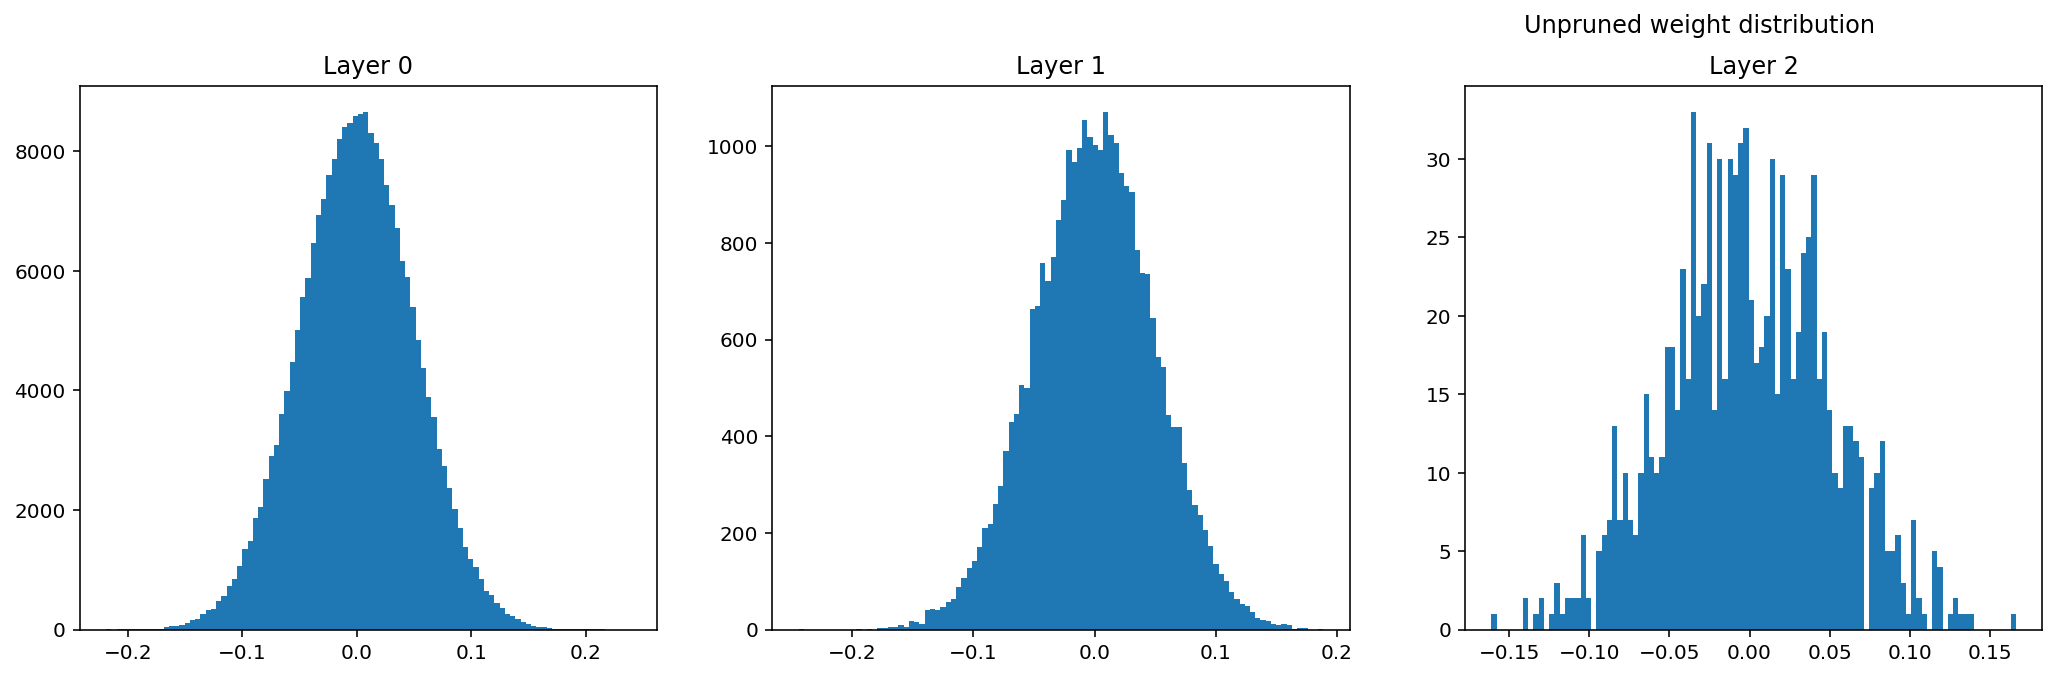

In [181]:
fig = plt.figure(figsize=(30,5))
fig.suptitle("Unpruned weight distribution")
for i,l in enumerate(fcn.layers):
    plt.subplot(1,5,i+1)
    plt.title(f"Layer {i}")
    _ = plt.hist(l.get_weights()[0].flatten(), bins=100)

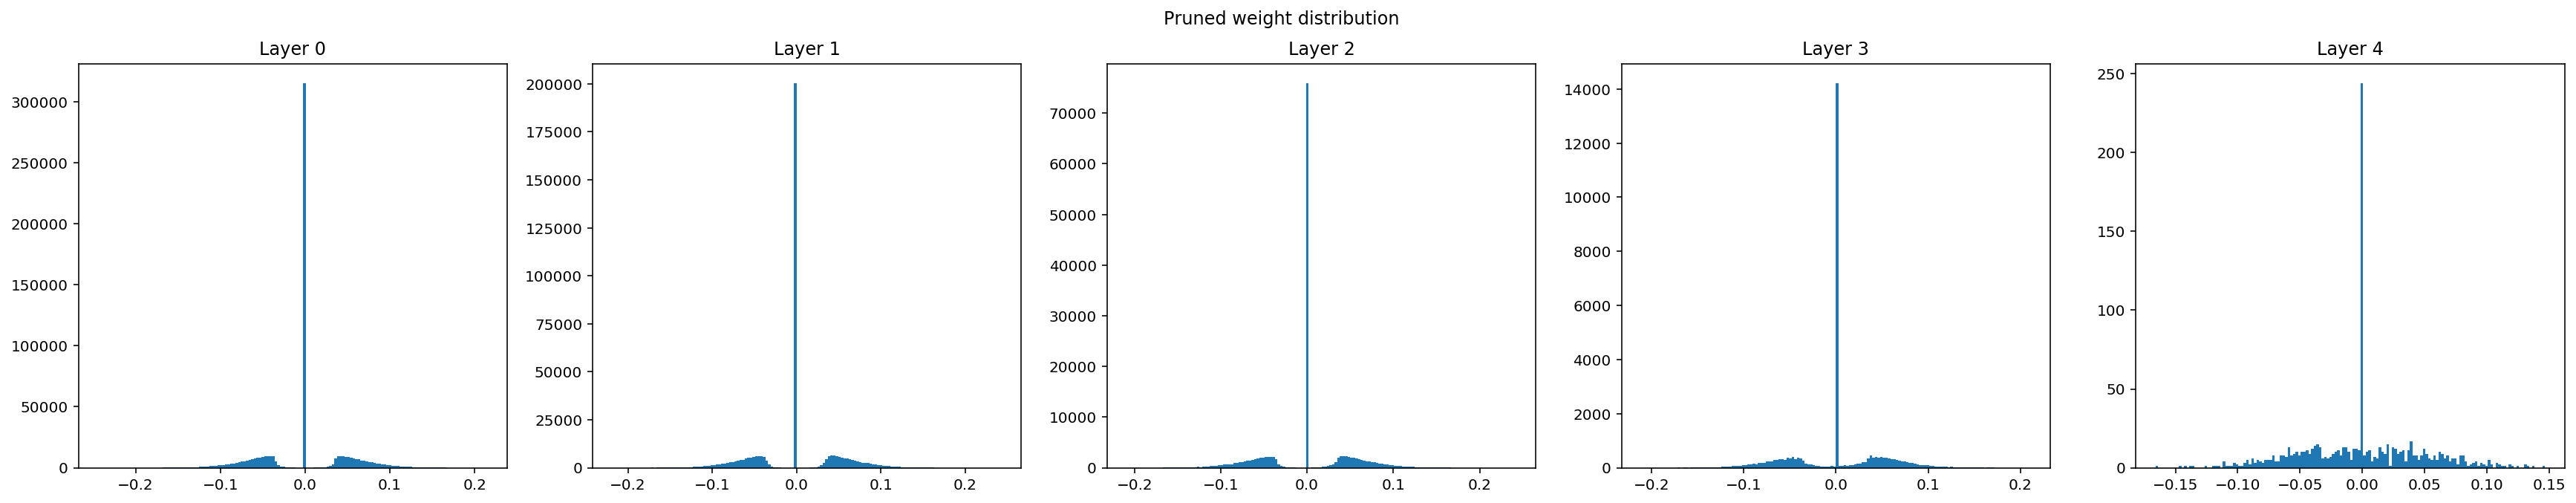

In [156]:
fig = plt.figure(figsize=(30,5))
fig.suptitle("Pruned weight distribution")
for i,l in enumerate(fcn.layers):
    plt.subplot(1,5,i+1)
    plt.title(f"Layer {i}")
    _ = plt.hist(l.get_masked_weights().numpy().flatten(), bins=150)

#_ = plt.hist(fcn.layers[0].get_masked_weights().numpy().flatten(), bins=100)

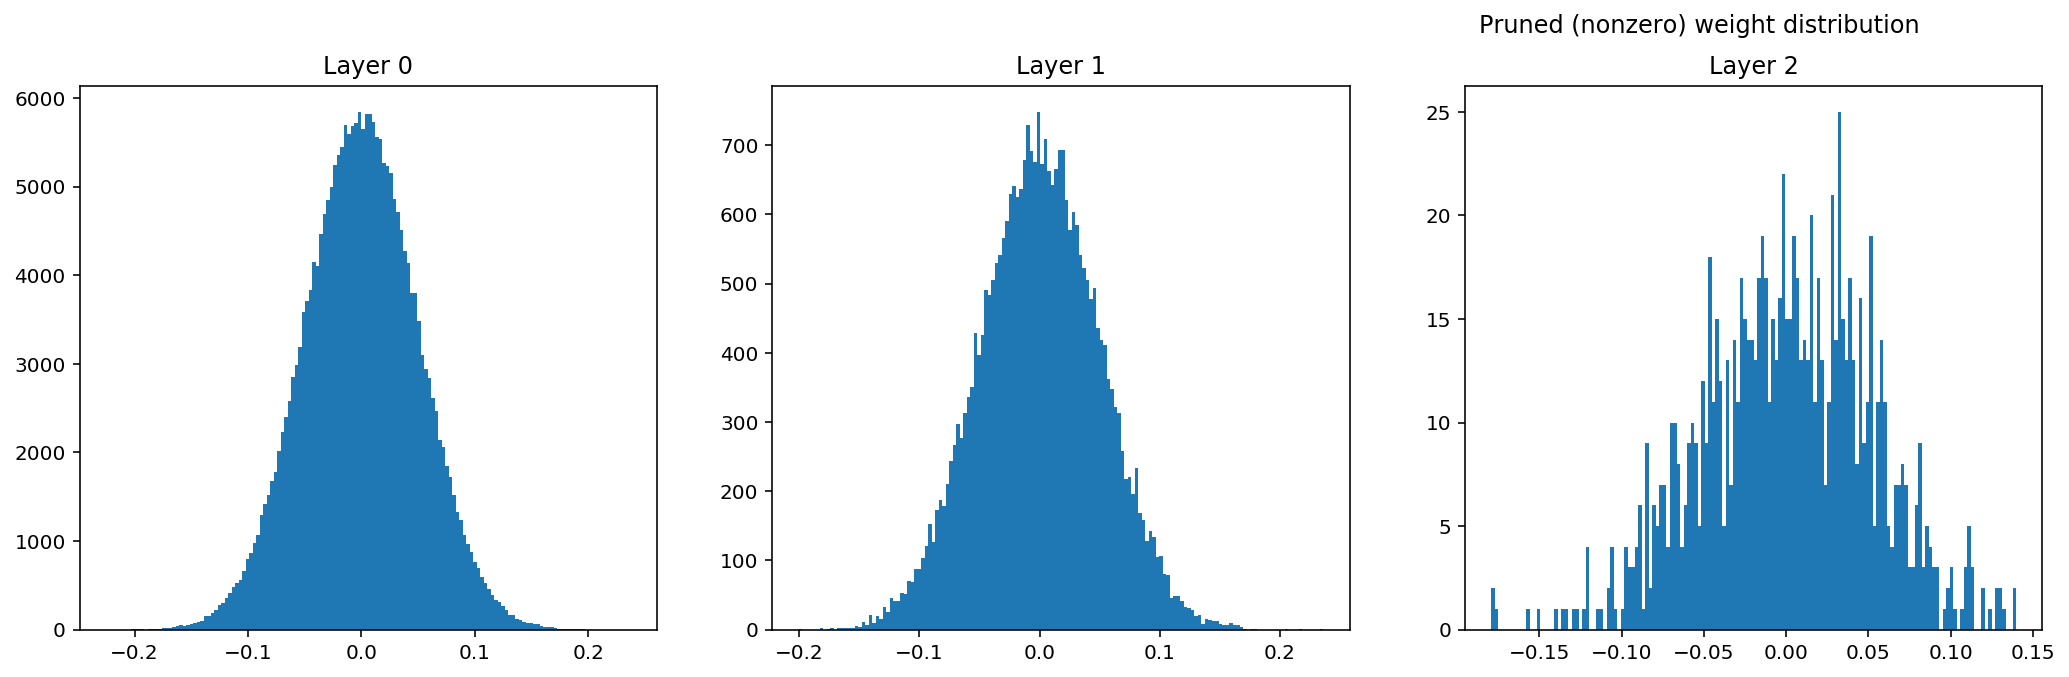

In [39]:
fig = plt.figure(figsize=(30,5))
fig.suptitle("Pruned (nonzero) weight distribution")
for i,l in enumerate(fcn.layers):
    plt.subplot(1,5,i+1)
    plt.title(f"Layer {i}")
    _ = plt.hist(l.get_nonzero_weights().numpy().flatten(), bins=150)

#_ = plt.hist(fcn.layers[0].get_masked_weights().numpy().flatten(), bins=100)

In [27]:
np.equal(fcn.layers[0].get_weights()[0],fcn.layers[0].get_masked_weights().numpy()).all()

True

In [30]:
init = initializer()

initializer


In [32]:
MU=0
MU_BI = [-0.13, 0.13]
SIGMA=-1 #0.1 IF SIGMA == -1 --> glorot normal
SIGMA_BI = [-SIGMA, SIGMA]
fcn, initial_weights = init.set_weights_man(fcn, mode="normal", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="./weights/initial_weights", weight_as_constant=False)

Glorot normal with sigma 0.0018
Glorot normal with sigma 0.0050
Glorot normal with sigma 0.0182


In [60]:
for i,l in enumerate(fcn.layers):
    l.set_weights(initial_weights[i])
    #l.weights[0] = initial_weights[i][0]

In [30]:
np.mean(initial_weights[0][0] - fcn.layers[0].weights[0])

0.0

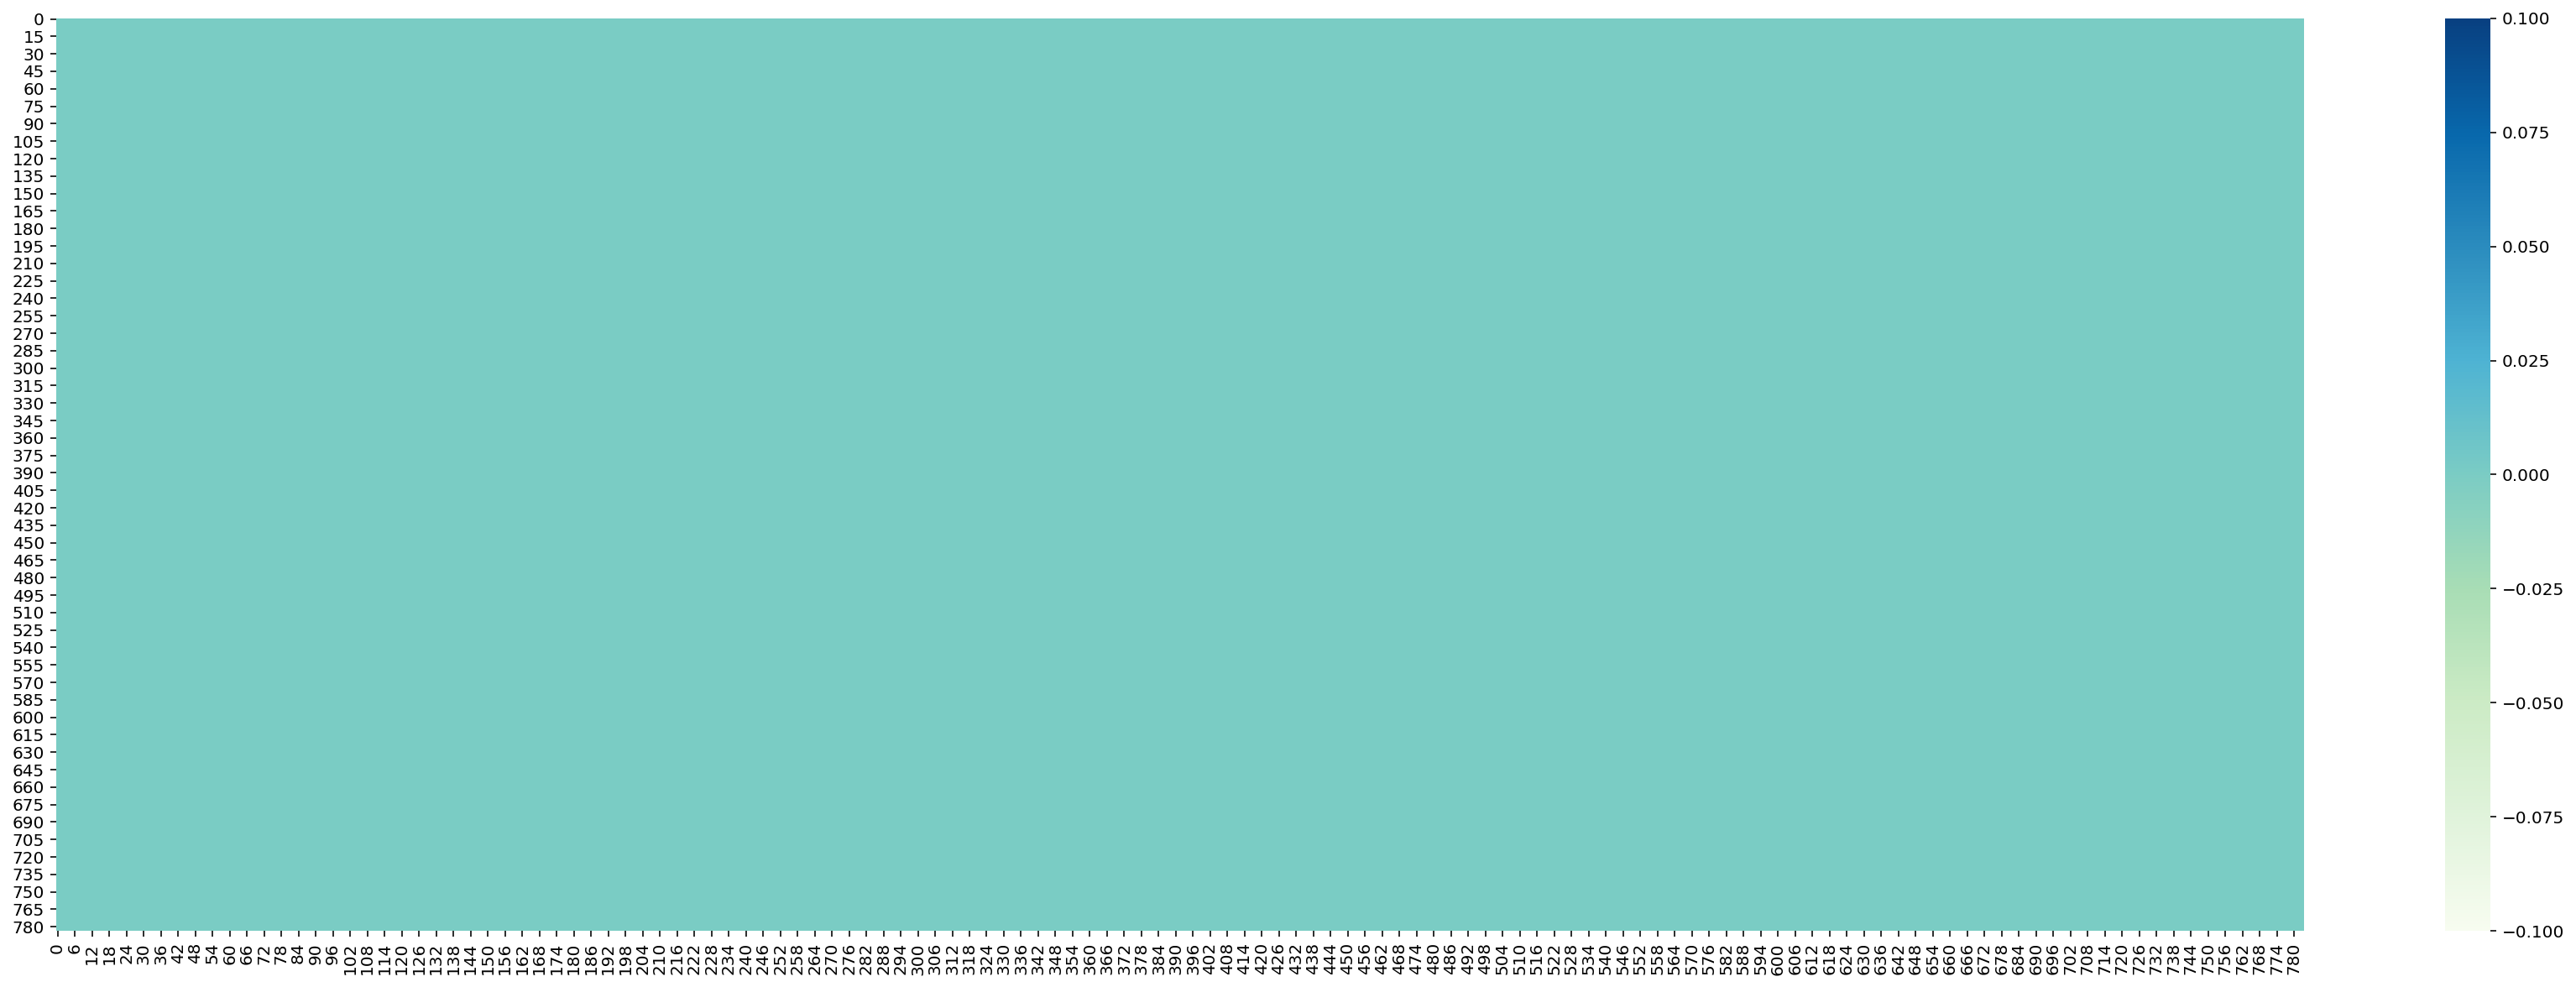

In [51]:
plt.figure(figsize=(30,10))
sns.heatmap(initial_weights[0][0] - fcn.layers[0].weights[0], cmap="GnBu")

In [97]:
for i,l in enumerate(fcn.layers):
    a = np.mean(initial_weights[i][0] - l.get_masked_weights())
    print(f"layer 1: {a}")

layer 1: 8.877714572008699e-05
layer 1: -0.00022741024440620095
layer 1: -0.0004929418209940195
layer 1: -0.0007177547086030245
layer 1: 0.0011860518716275692


In [384]:
for i,l in enumerate(fcn.layers):
    a = np.mean(initial_weights[i][0] - l.get_weights()[0])
    print(f"layer {i}: {a}")

layer 0: 0.0001405421982747834
layer 1: -0.000522469607457697
layer 2: -0.0011903249881008604
layer 3: -0.0030908669201987118
layer 4: -7.691849107346881e-08


In [ ]:
for i,all_weights_iter in enumerate(all_weights):
    fig = plt.figure(figsize=(30,5))
    if i == 0:
        fig.suptitle("(Unpruned) Weight Distribution at Iteration (Re-)Initialization")
    else:
        fig.suptitle(f"(Unpruned) Weight Distribution at Iteration {i}")
    for j,all_weights_layer in enumerate (all_weights_iter):
        plt.subplot(1,5,j+1)
        plt.title(f"Layer {j}")
        _ = plt.hist(all_weights_layer.flatten(), bins=120)

In [40]:
iter(ds_train).next()[0].numpy()[0].reshape(28,28)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

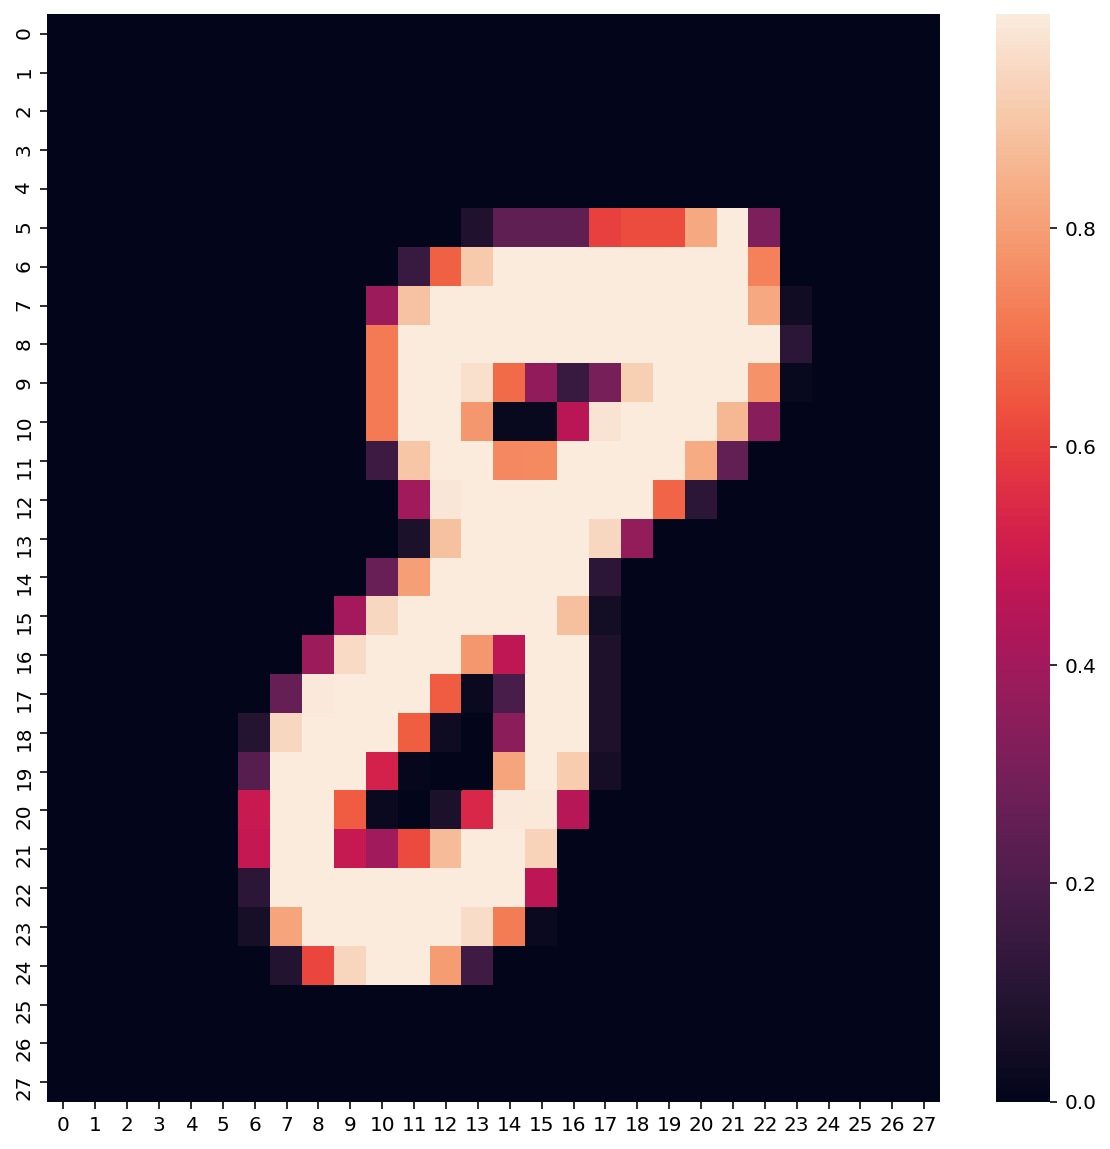

In [42]:
sns.heatmap(iter(ds_train).next()[0].numpy()[0].reshape(28,28))

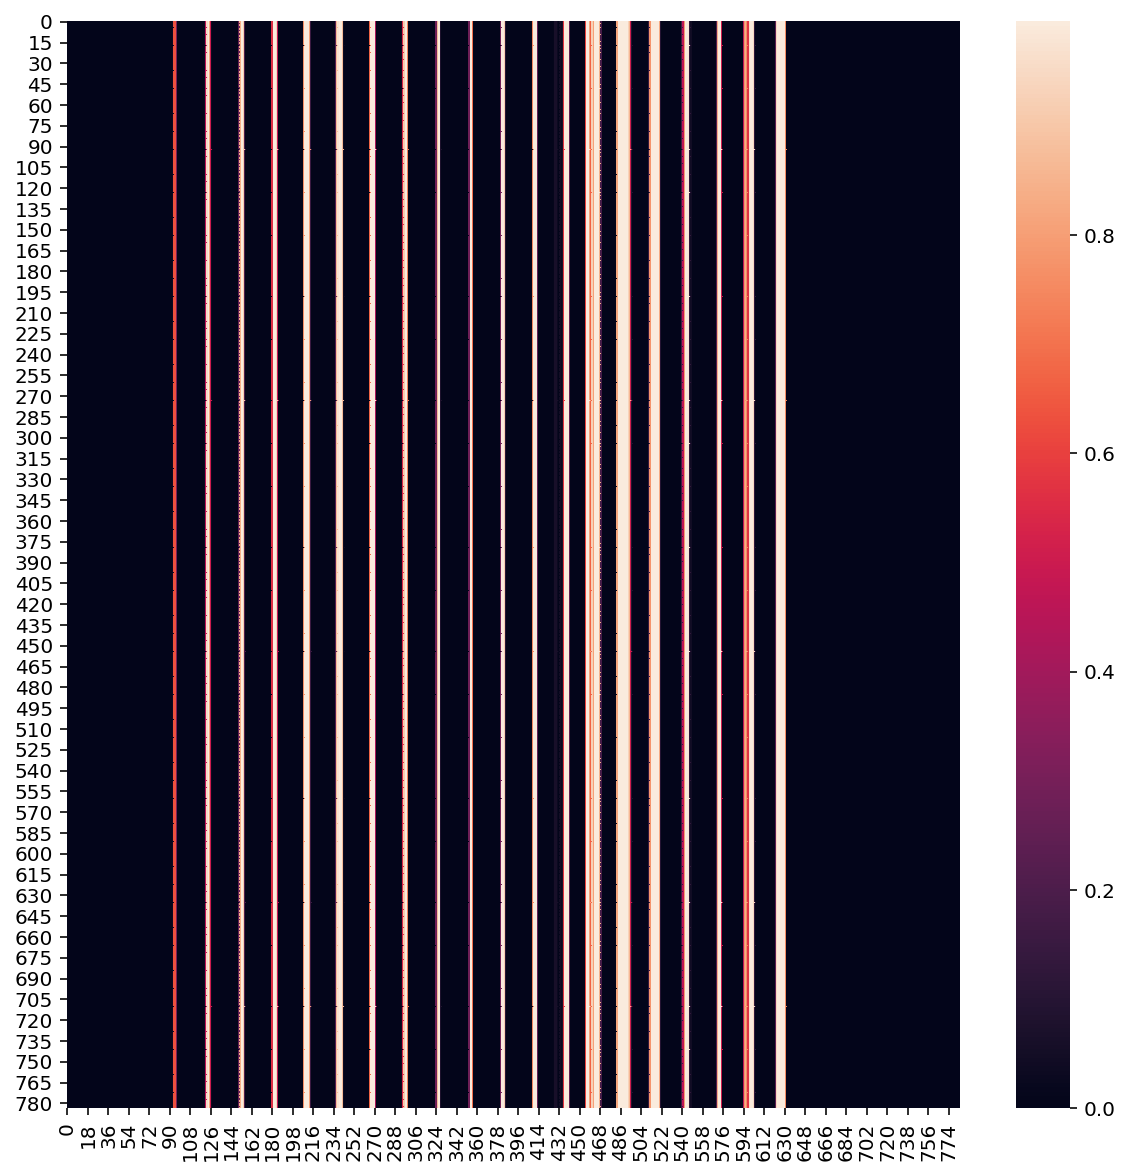

In [23]:
sns.heatmap(iter(ds_train).next()[0].numpy()[0] * fcn.layers[0].get_mask().numpy())

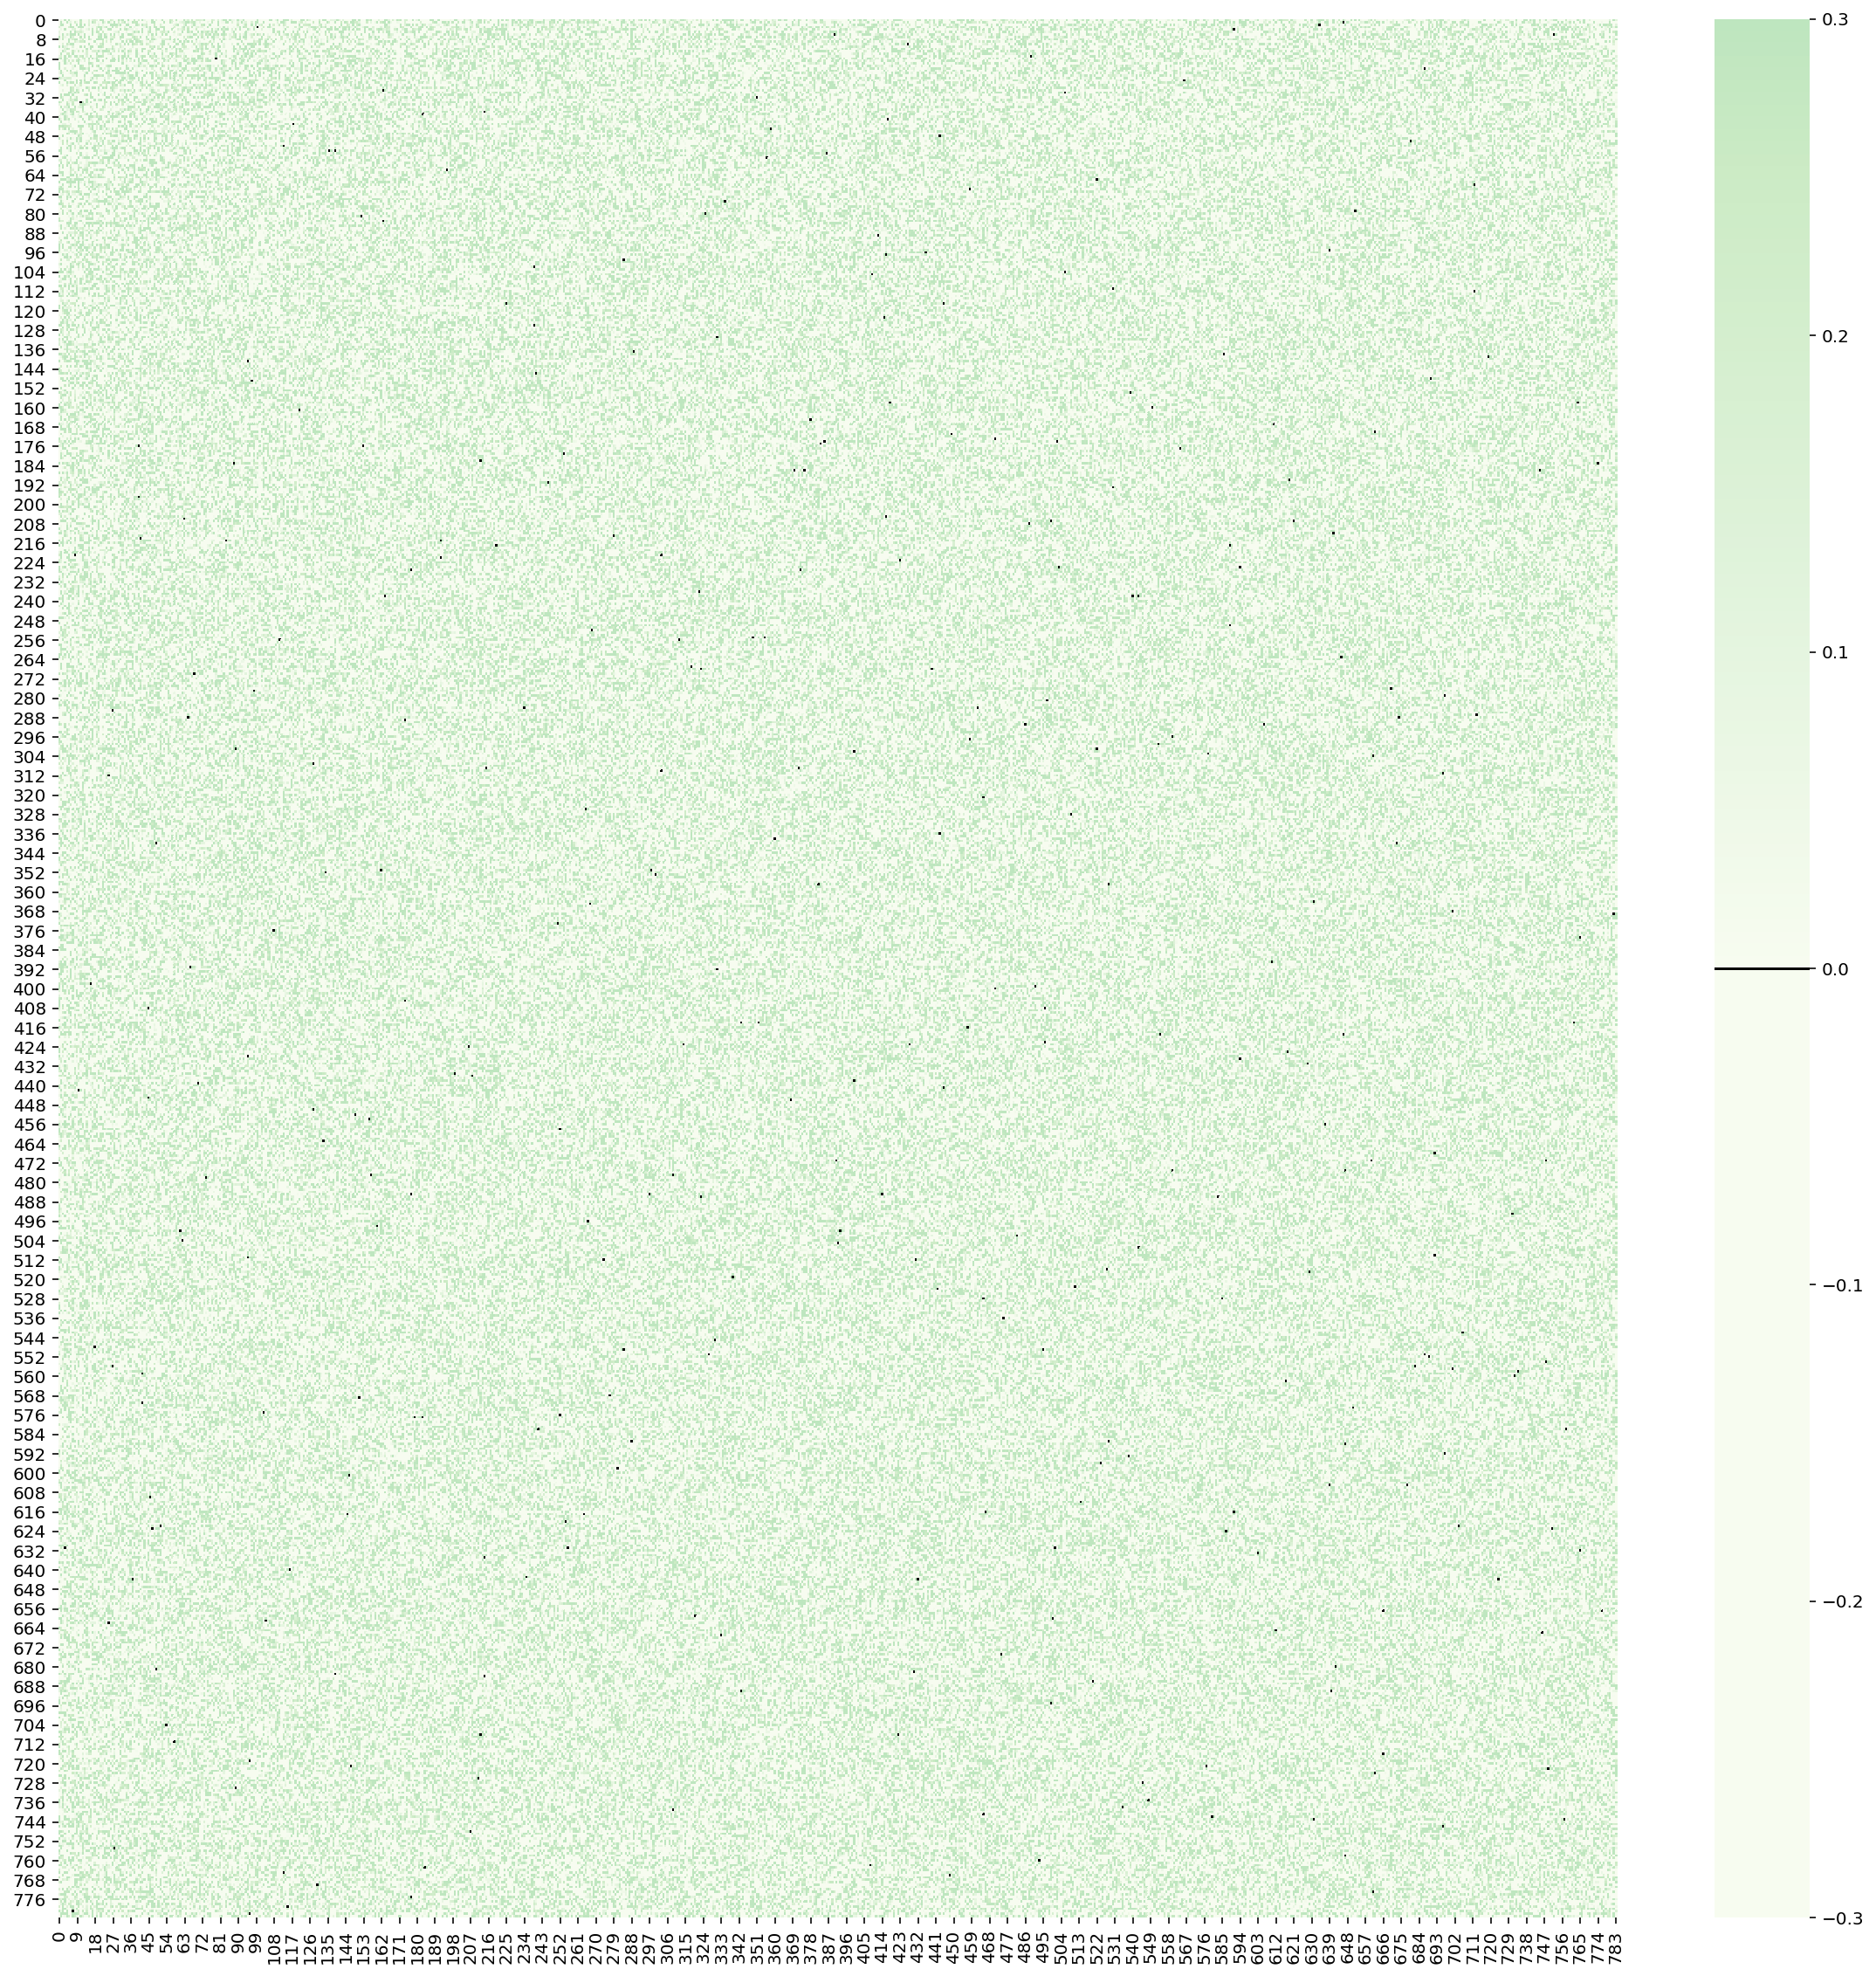

In [24]:
plt.figure(figsize=(20,20))
sns.heatmap(fcn.layers[0].get_masked_weights().numpy(), cmap=cmap, vmin=-0.3, vmax=0.3)

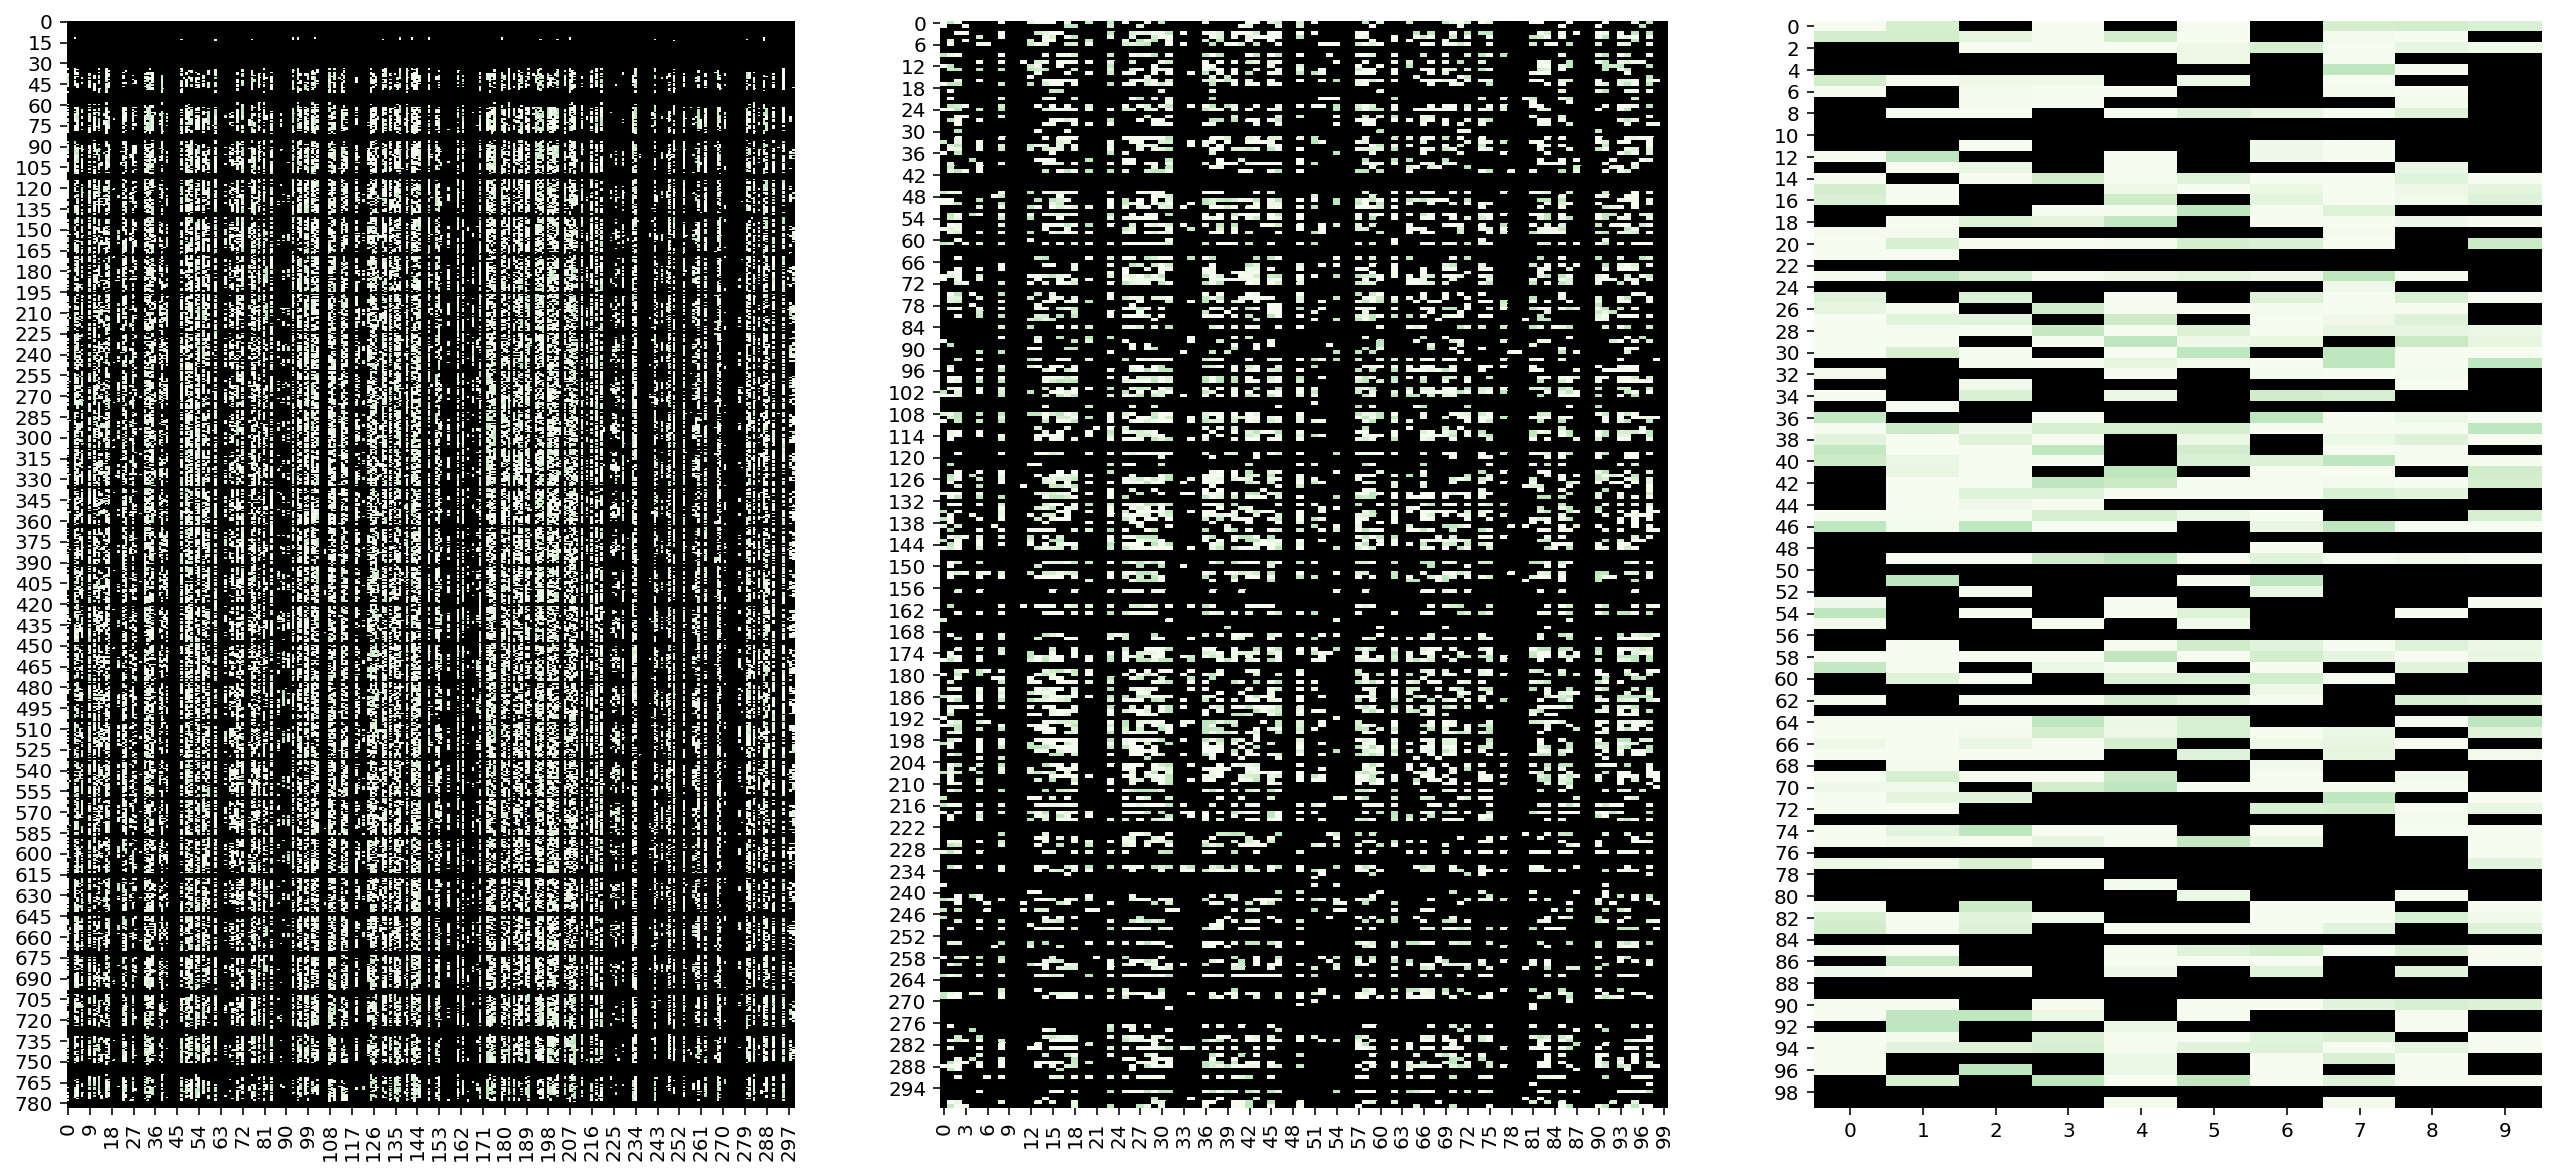

In [33]:
fig = plt.figure(figsize=(30,10))
for i, layer in enumerate(fcn.layers):
    plt.subplot(1,4,i+1)
    sns.heatmap(layer.get_masked_weights(), cmap=cmap, vmin=-0.3, vmax=0.3, cbar=False)

In [53]:
fig = plt.figure(figsize=(30,10))
for i, layer in enumerate(smaller_fcn.layers):
    plt.subplot(1,4,i+1)
    sns.heatmap(layer.get_masked_weights(), cmap=cmap, vmin=-0.3, vmax=0.3, cbar=False)

NameError: name 'smaller_fcn' is not defined

<Figure size 2160x720 with 0 Axes>

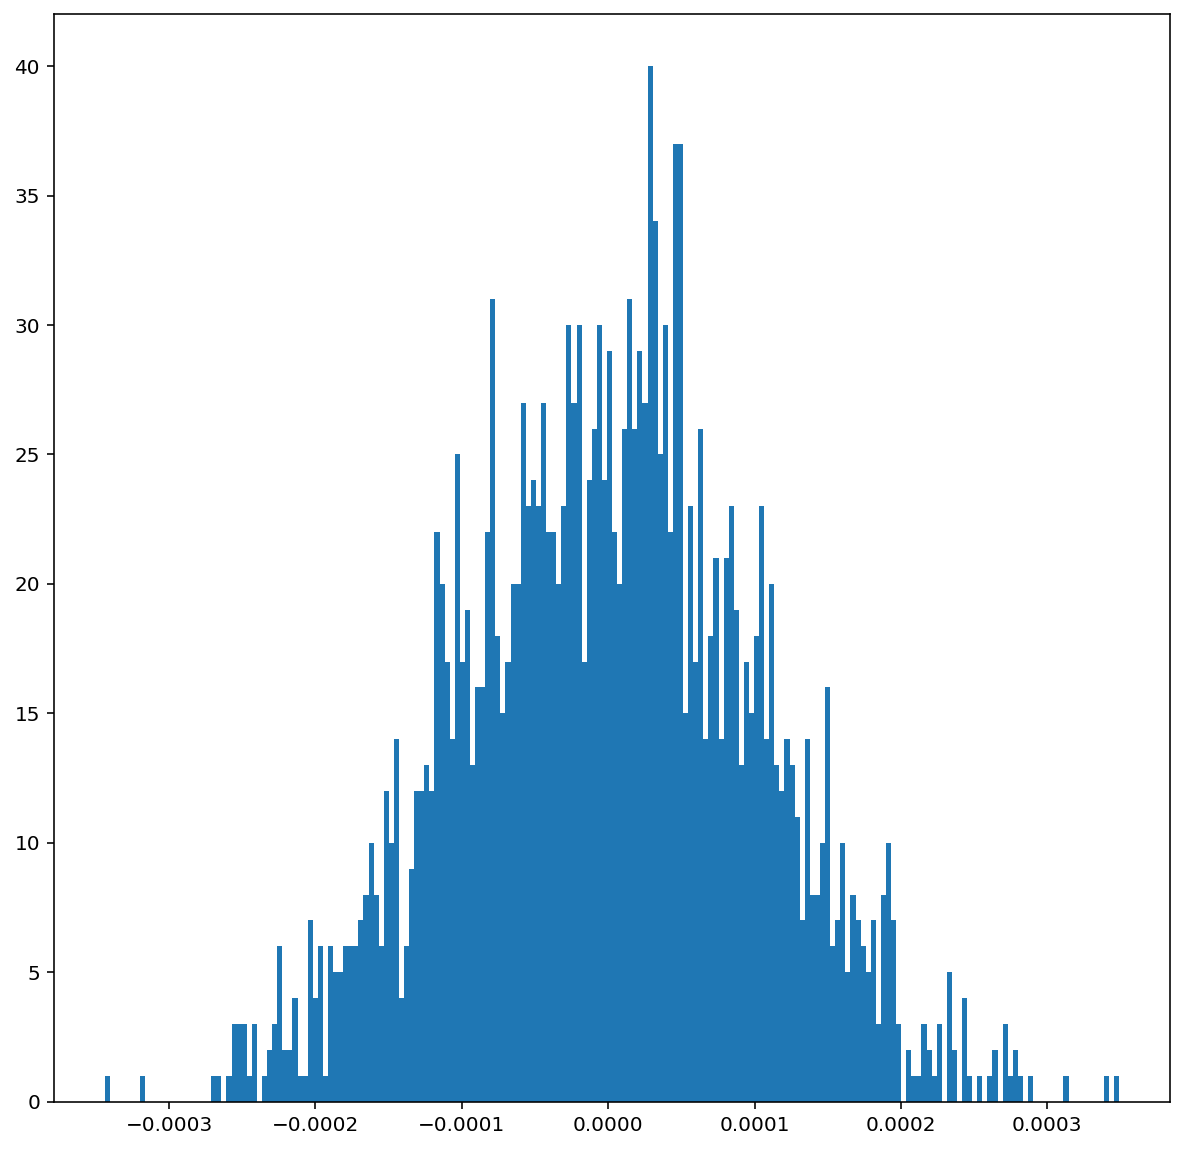

In [35]:
_ = plt.hist(0.0001 * np.random.randn(2000), bins=200)

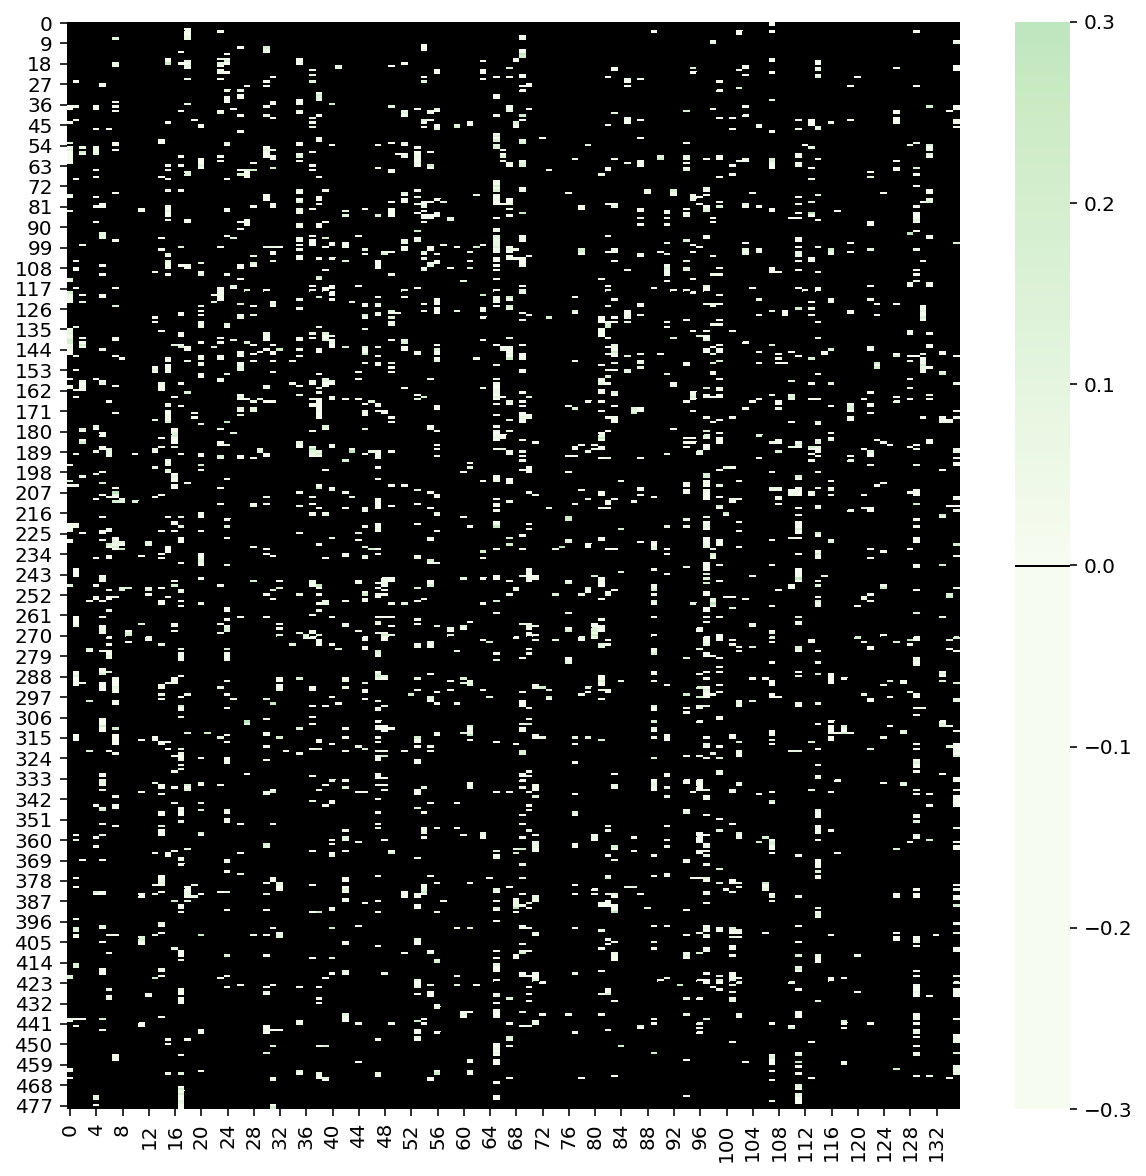

In [130]:
sns.heatmap(a[b[:,None], c], cmap=cmap, vmin=-0.3, vmax=0.3)

In [77]:
a[b]

array([[ 0.,  0.,  0., ...,  0.,  0., -0.],
       [ 0., -0.,  0., ..., -0., -0.,  0.],
       [ 0.,  0., -0., ..., -0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0., -0., ..., -0.,  0.,  0.],
       [-0.,  0.,  0., ..., -0., -0.,  0.]], dtype=float32)

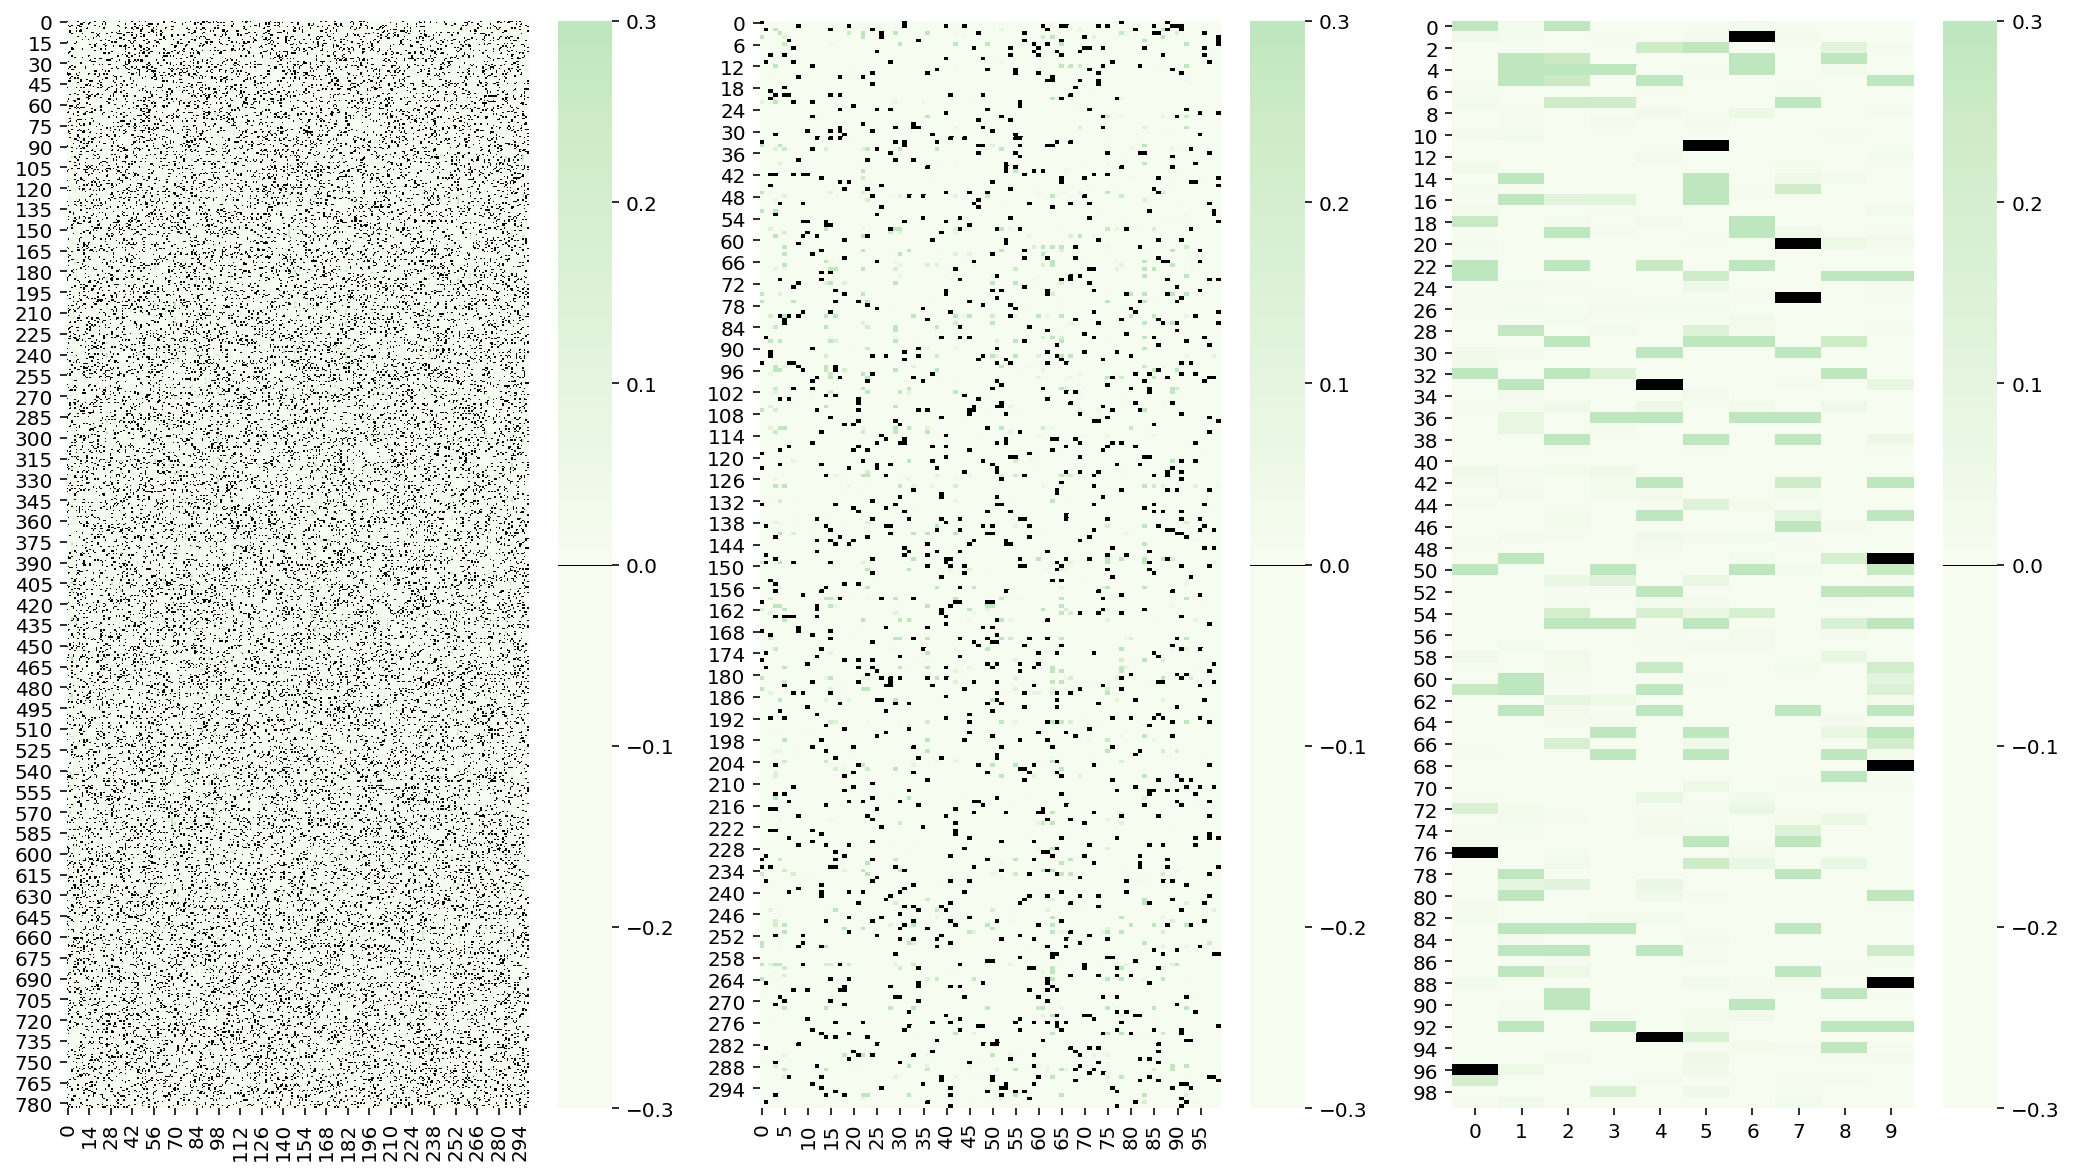

In [79]:
fig = plt.figure(figsize=(30,10))
for i, layer in enumerate(fcn.layers):
    plt.subplot(1,5,i+1)
    sns.heatmap(layer.get_weights()[0], cmap=cmap, vmin=-0.3, vmax=0.3, cbar=True)

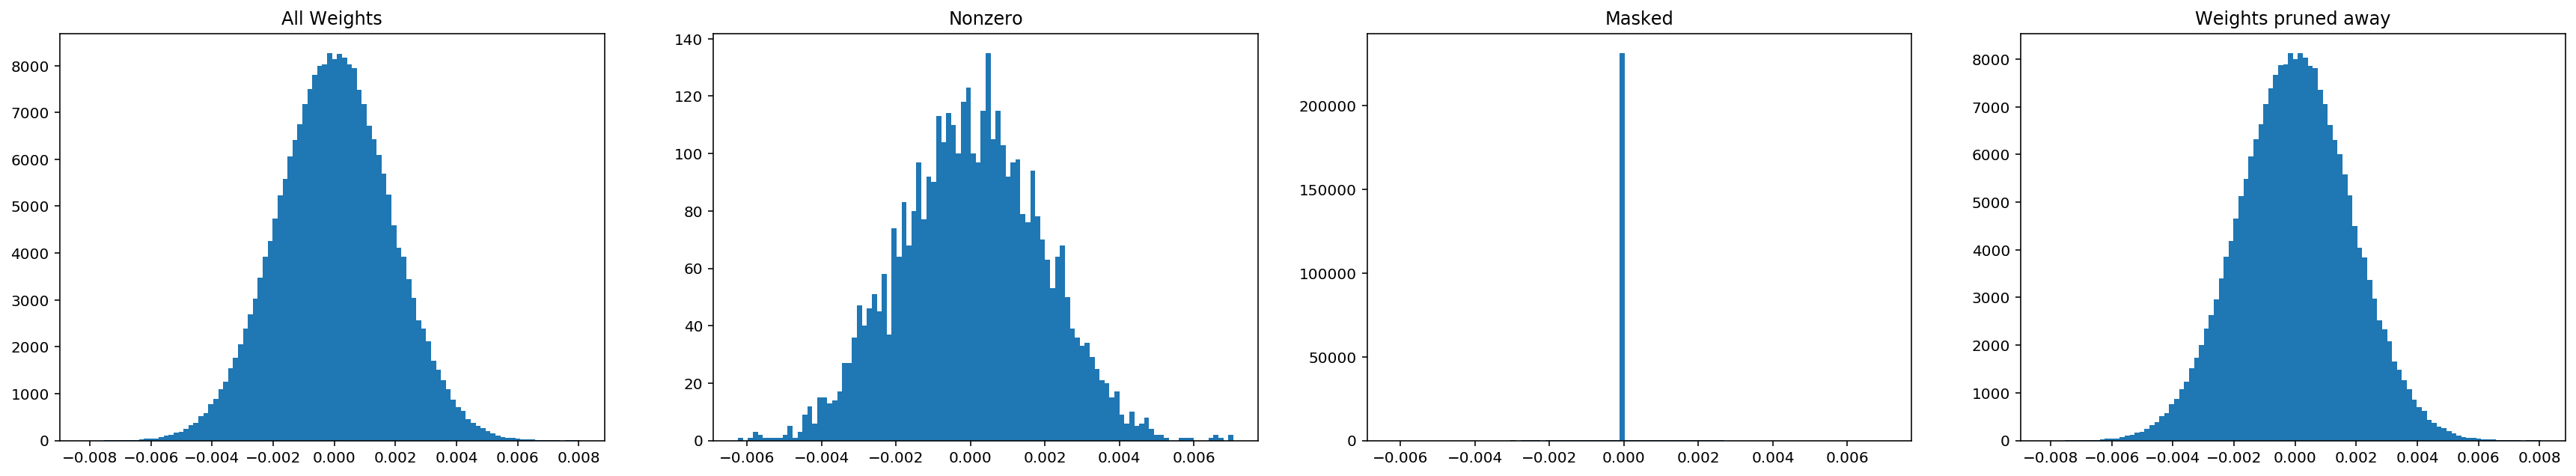

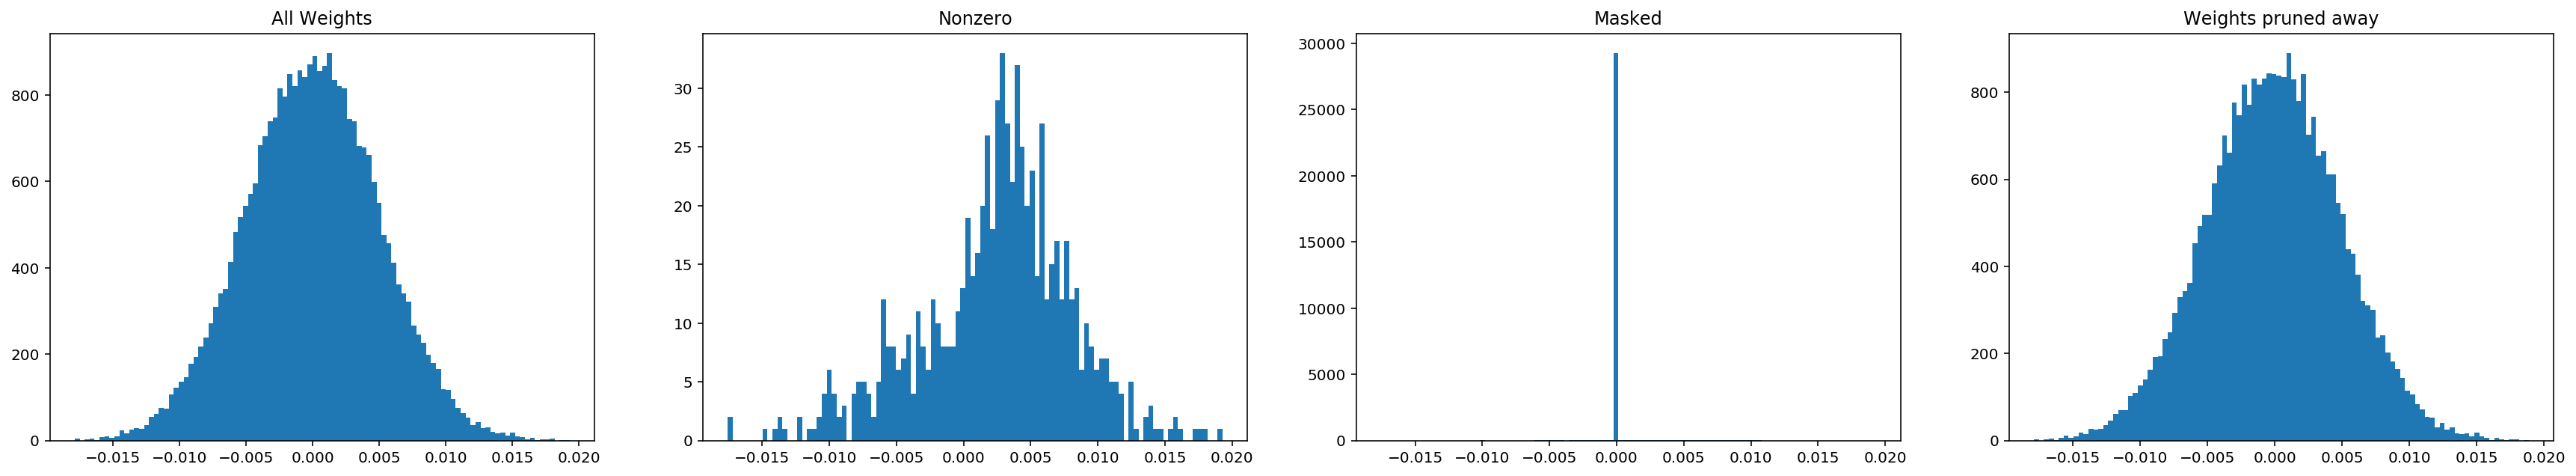

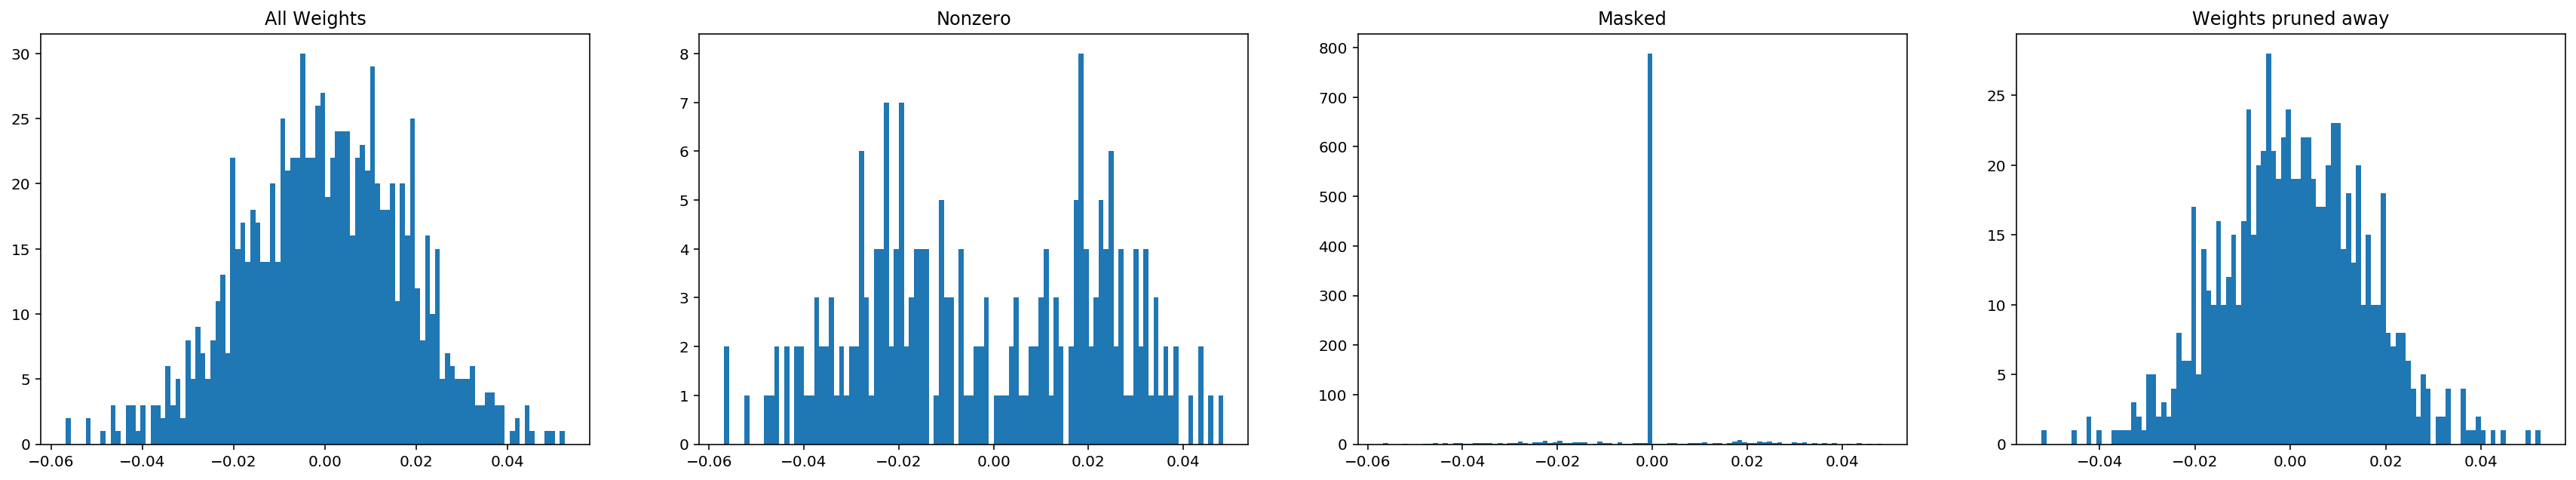

In [49]:
for i, layer in enumerate(fcn.layers):
    plt.figure(figsize=(30,5))
    plt.subplot(1,4,1)
    plt.title("All Weights")
    _ = plt.hist(layer.get_weights()[0].flatten(), bins=100)
    plt.subplot(1,4,2)
    plt.title("Nonzero")
    _ = plt.hist(layer.get_nonzero_weights().numpy().flatten(), bins=100)
    plt.subplot(1,4,3)
    plt.title("Masked")
    _ = plt.hist(layer.get_masked_weights().numpy().flatten(), bins=100)
    plt.subplot(1,4,4)
    plt.title("Weights pruned away")
    pruned_away = layer.get_pruned_weights().numpy().flatten()
    pruned_away_nonzero = pruned_away[np.nonzero(pruned_away)]
    _ = plt.hist(pruned_away_nonzero, bins=100)

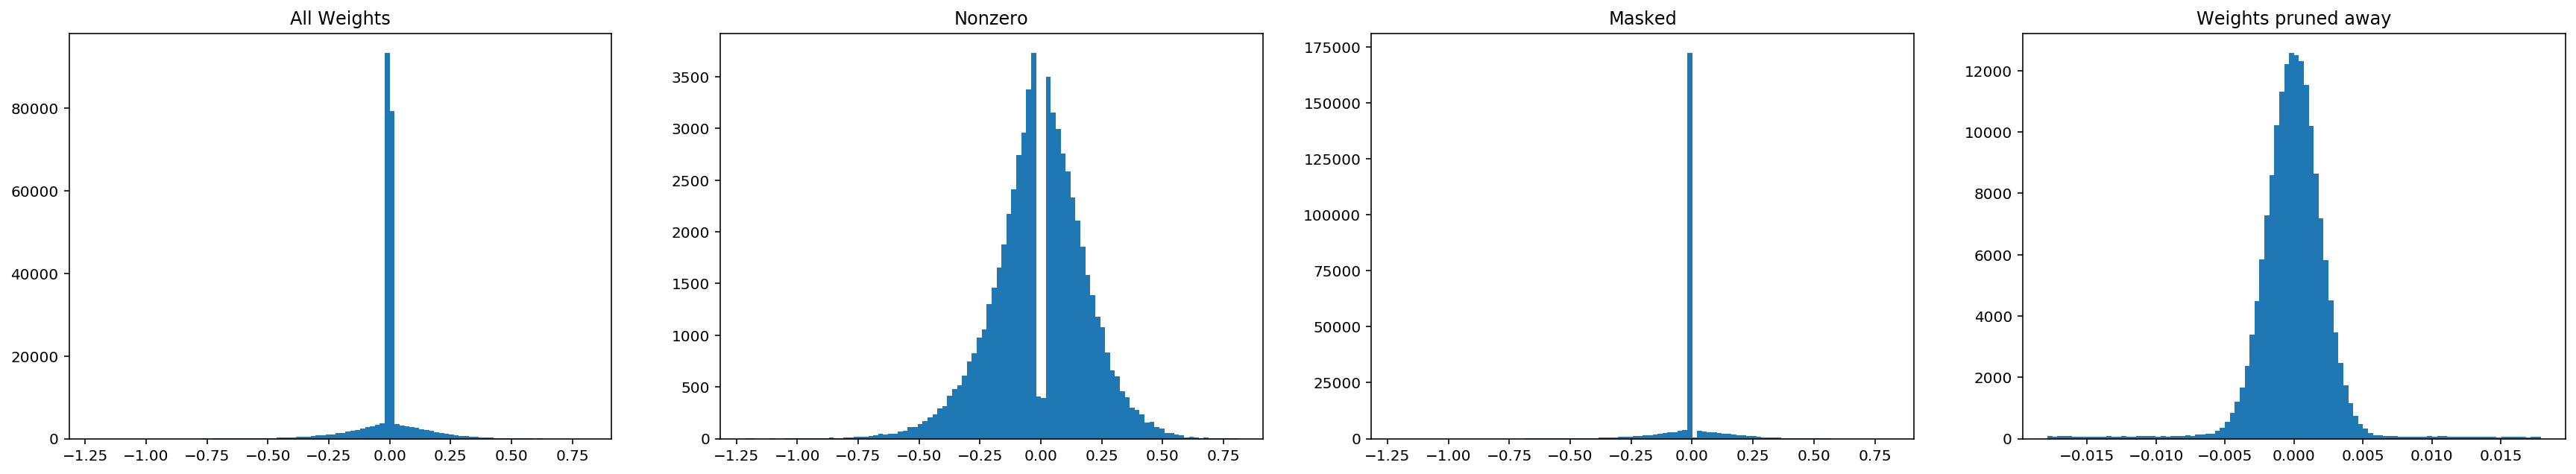

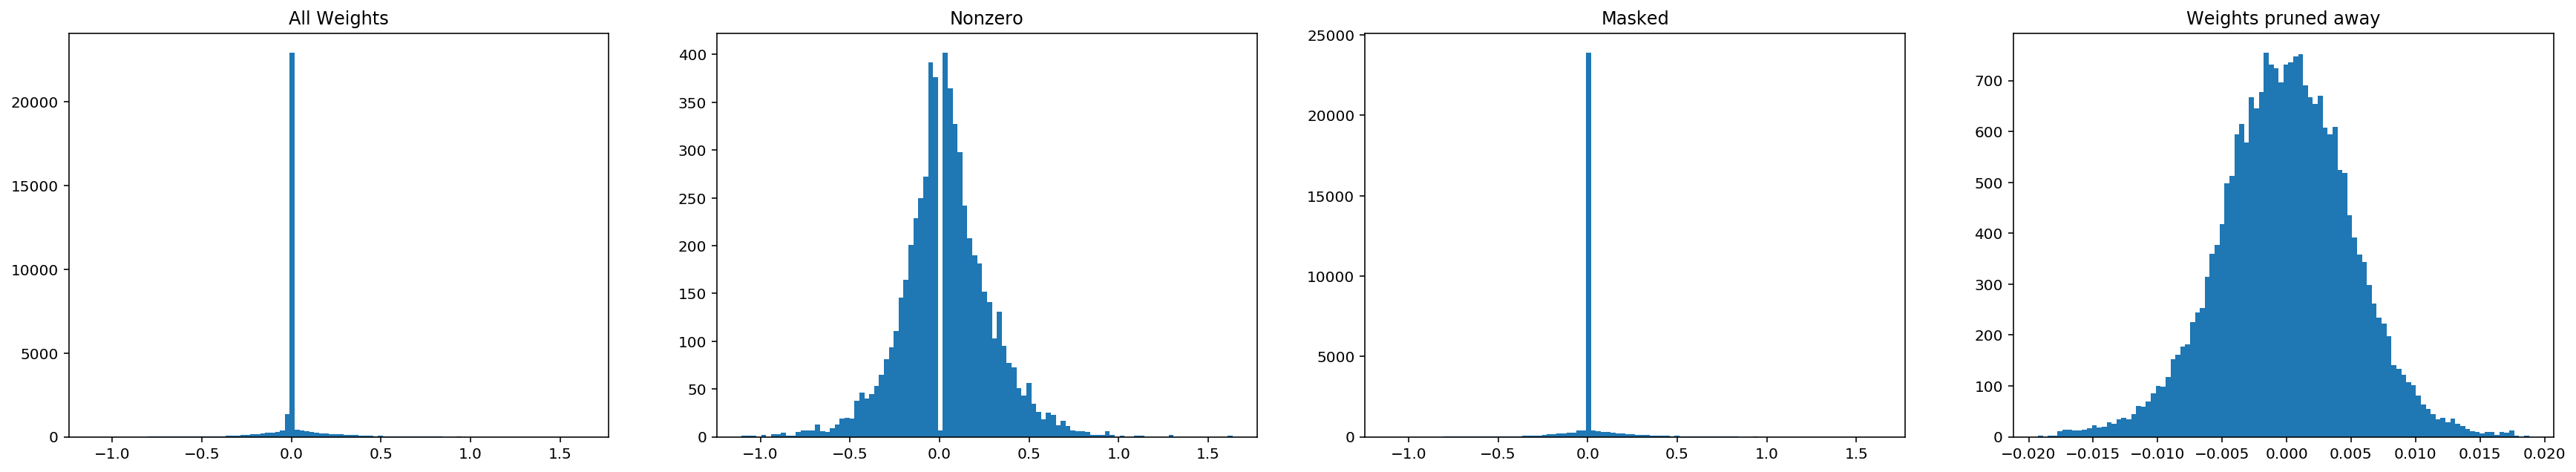

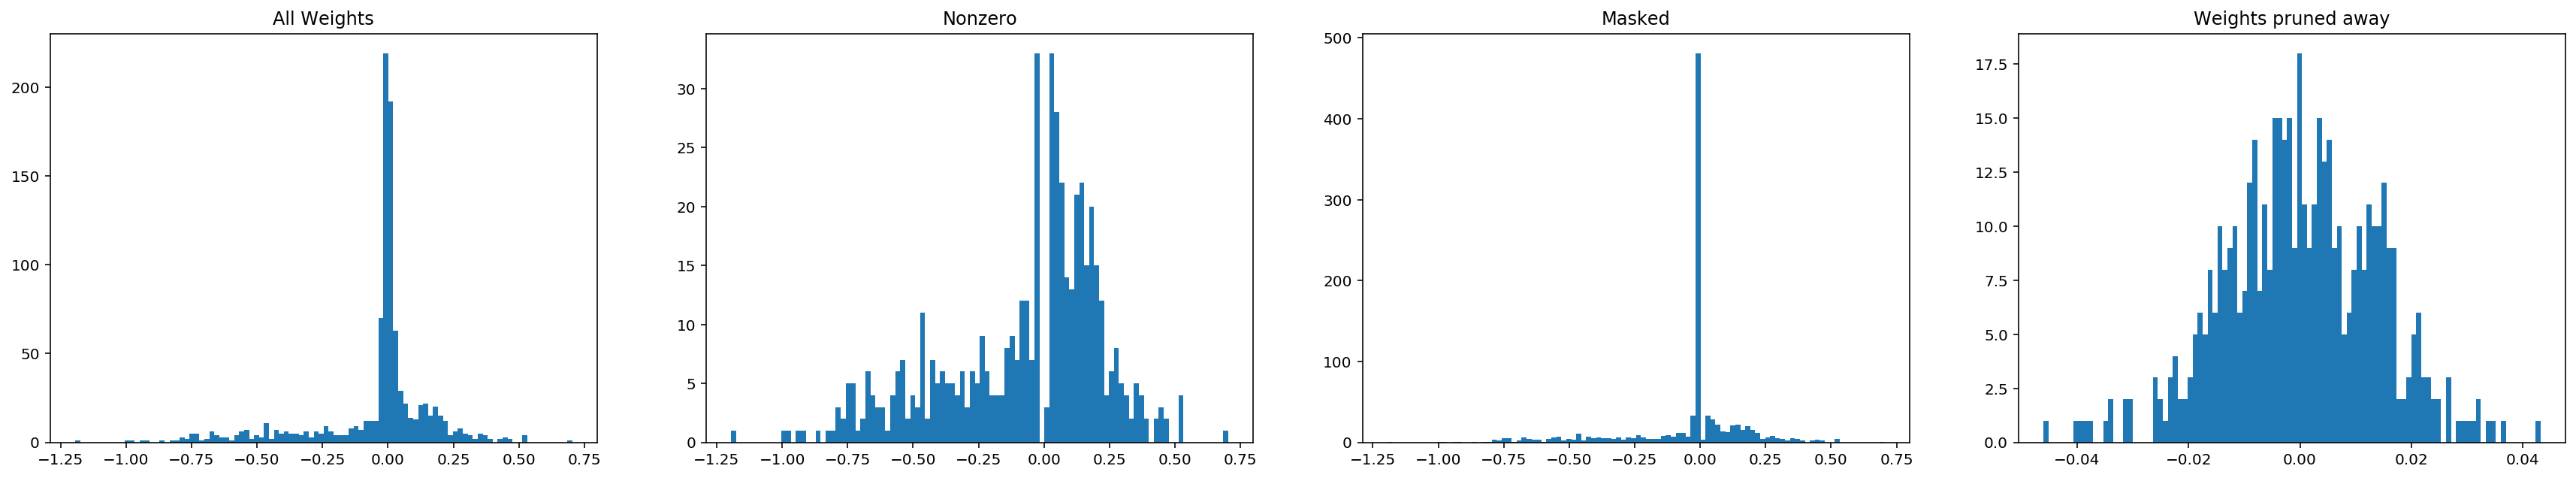

In [30]:
for i, layer in enumerate(smaller_fcn.layers):
    plt.figure(figsize=(30,5))
    plt.subplot(1,4,1)
    plt.title("All Weights")
    _ = plt.hist(layer.get_weights()[0].flatten(), bins=100)
    plt.subplot(1,4,2)
    plt.title("Nonzero")
    _ = plt.hist(layer.get_nonzero_weights().numpy().flatten(), bins=100)
    plt.subplot(1,4,3)
    plt.title("Masked")
    _ = plt.hist(layer.get_masked_weights().numpy().flatten(), bins=100)
    plt.subplot(1,4,4)
    plt.title("Weights pruned away")
    pruned_away = layer.get_pruned_weights().numpy().flatten()
    pruned_away_nonzero = pruned_away[np.nonzero(pruned_away)]
    _ = plt.hist(pruned_away_nonzero, bins=100)

Is Pruning driving the distribution apart no matter how it will look like initially?  
Try different Distributions, also skewed etc

In [58]:
a = np.nonzero(fcn.layers[0].get_mask().numpy())

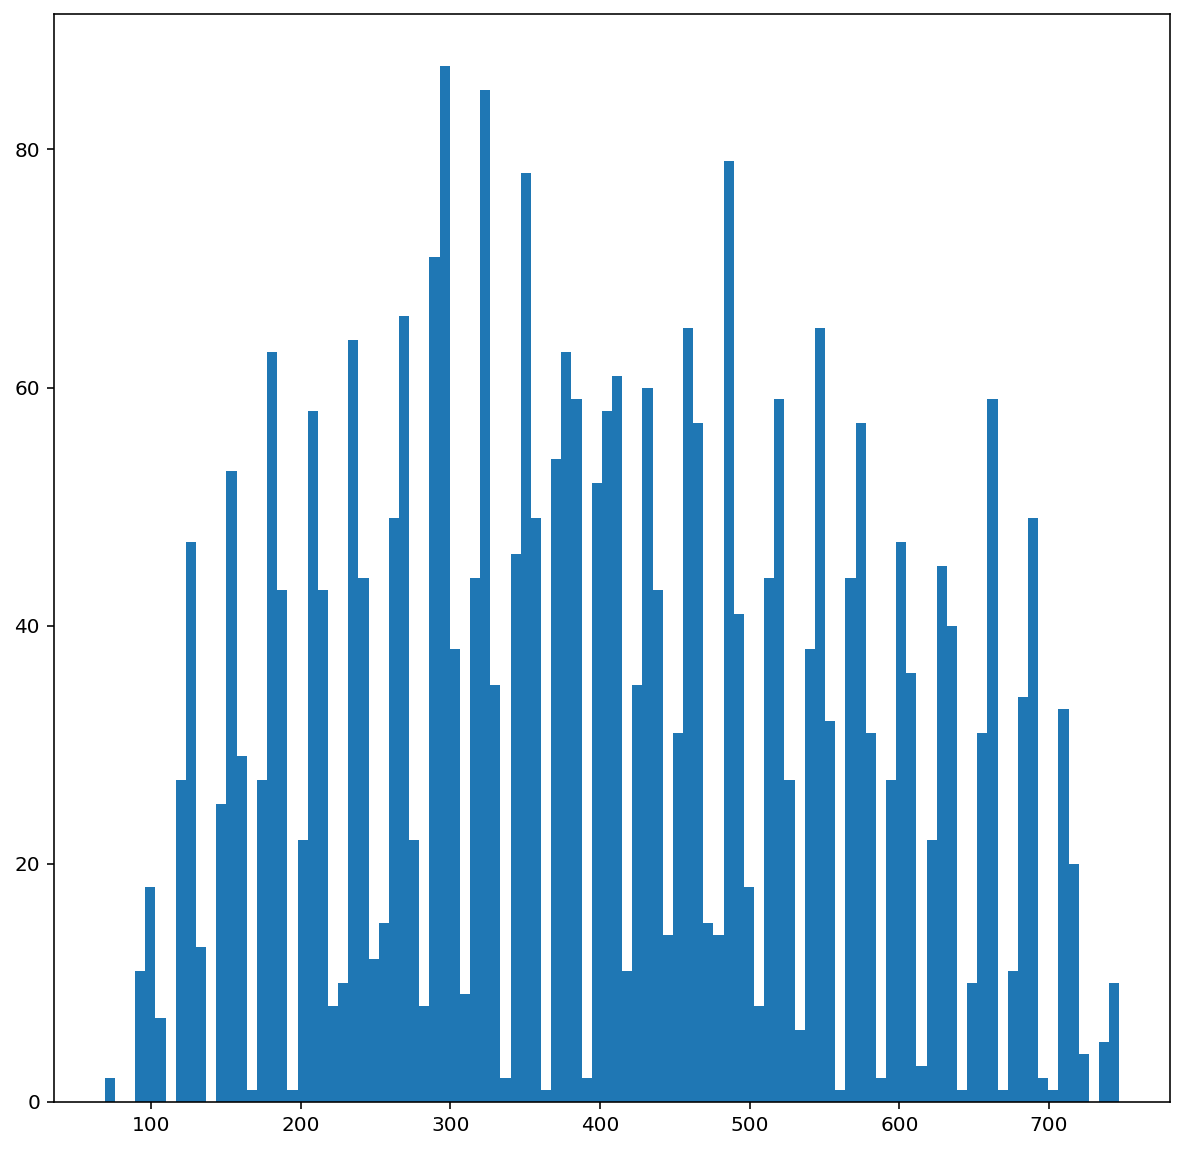

In [59]:
_ = plt.hist(a[0], bins=100)

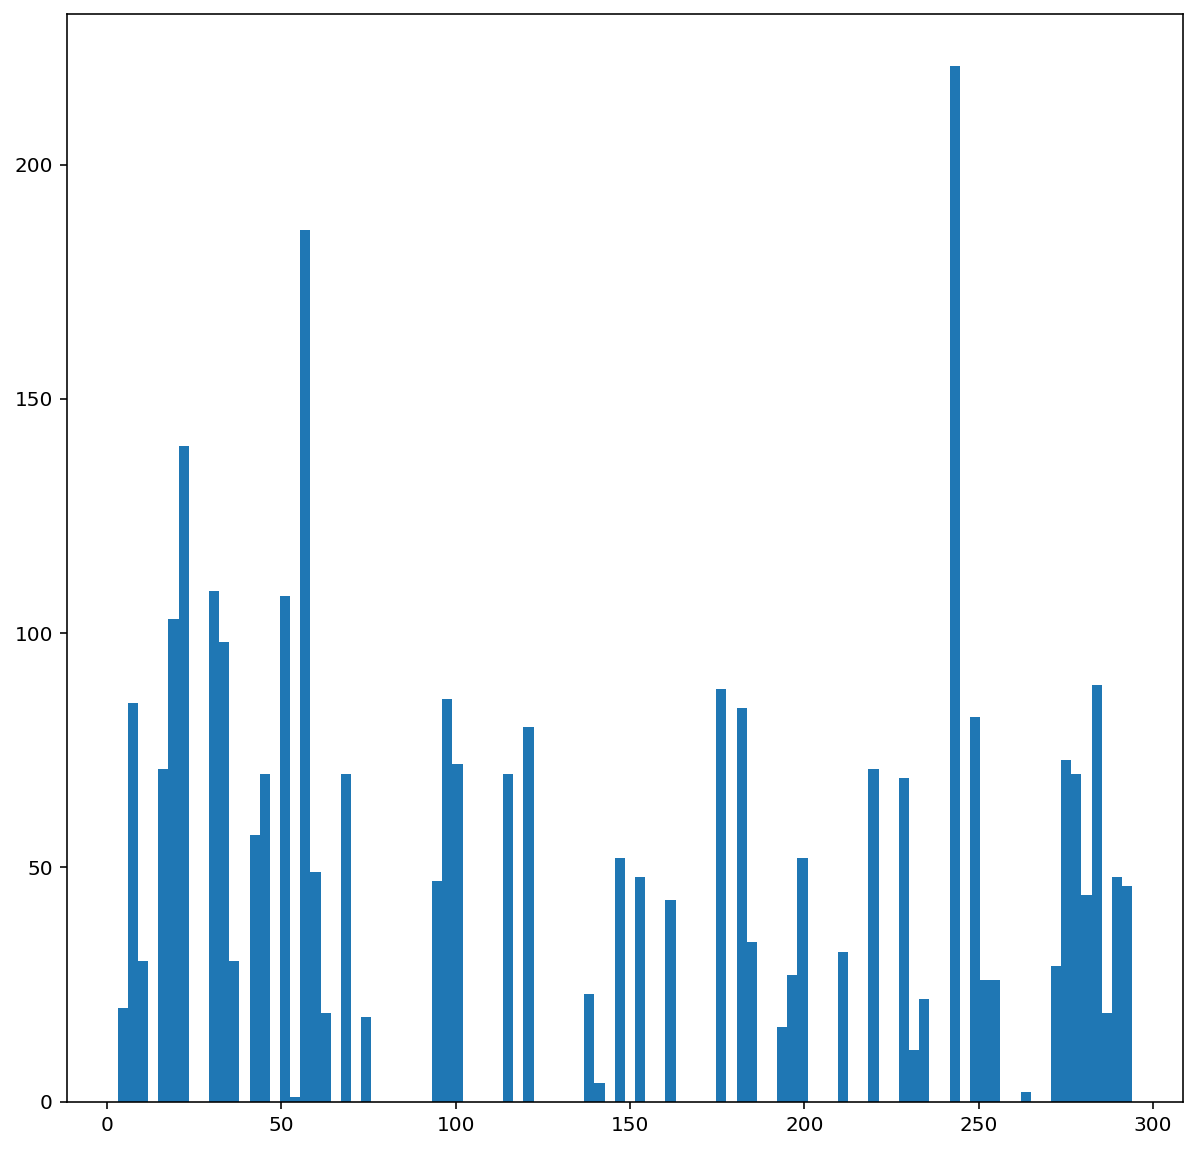

In [60]:
_ = plt.hist(a[1], bins=100)

Text(0.5, 1.0, "Each dot represents a 1 in the mask i.e. letting the weight 'through'")

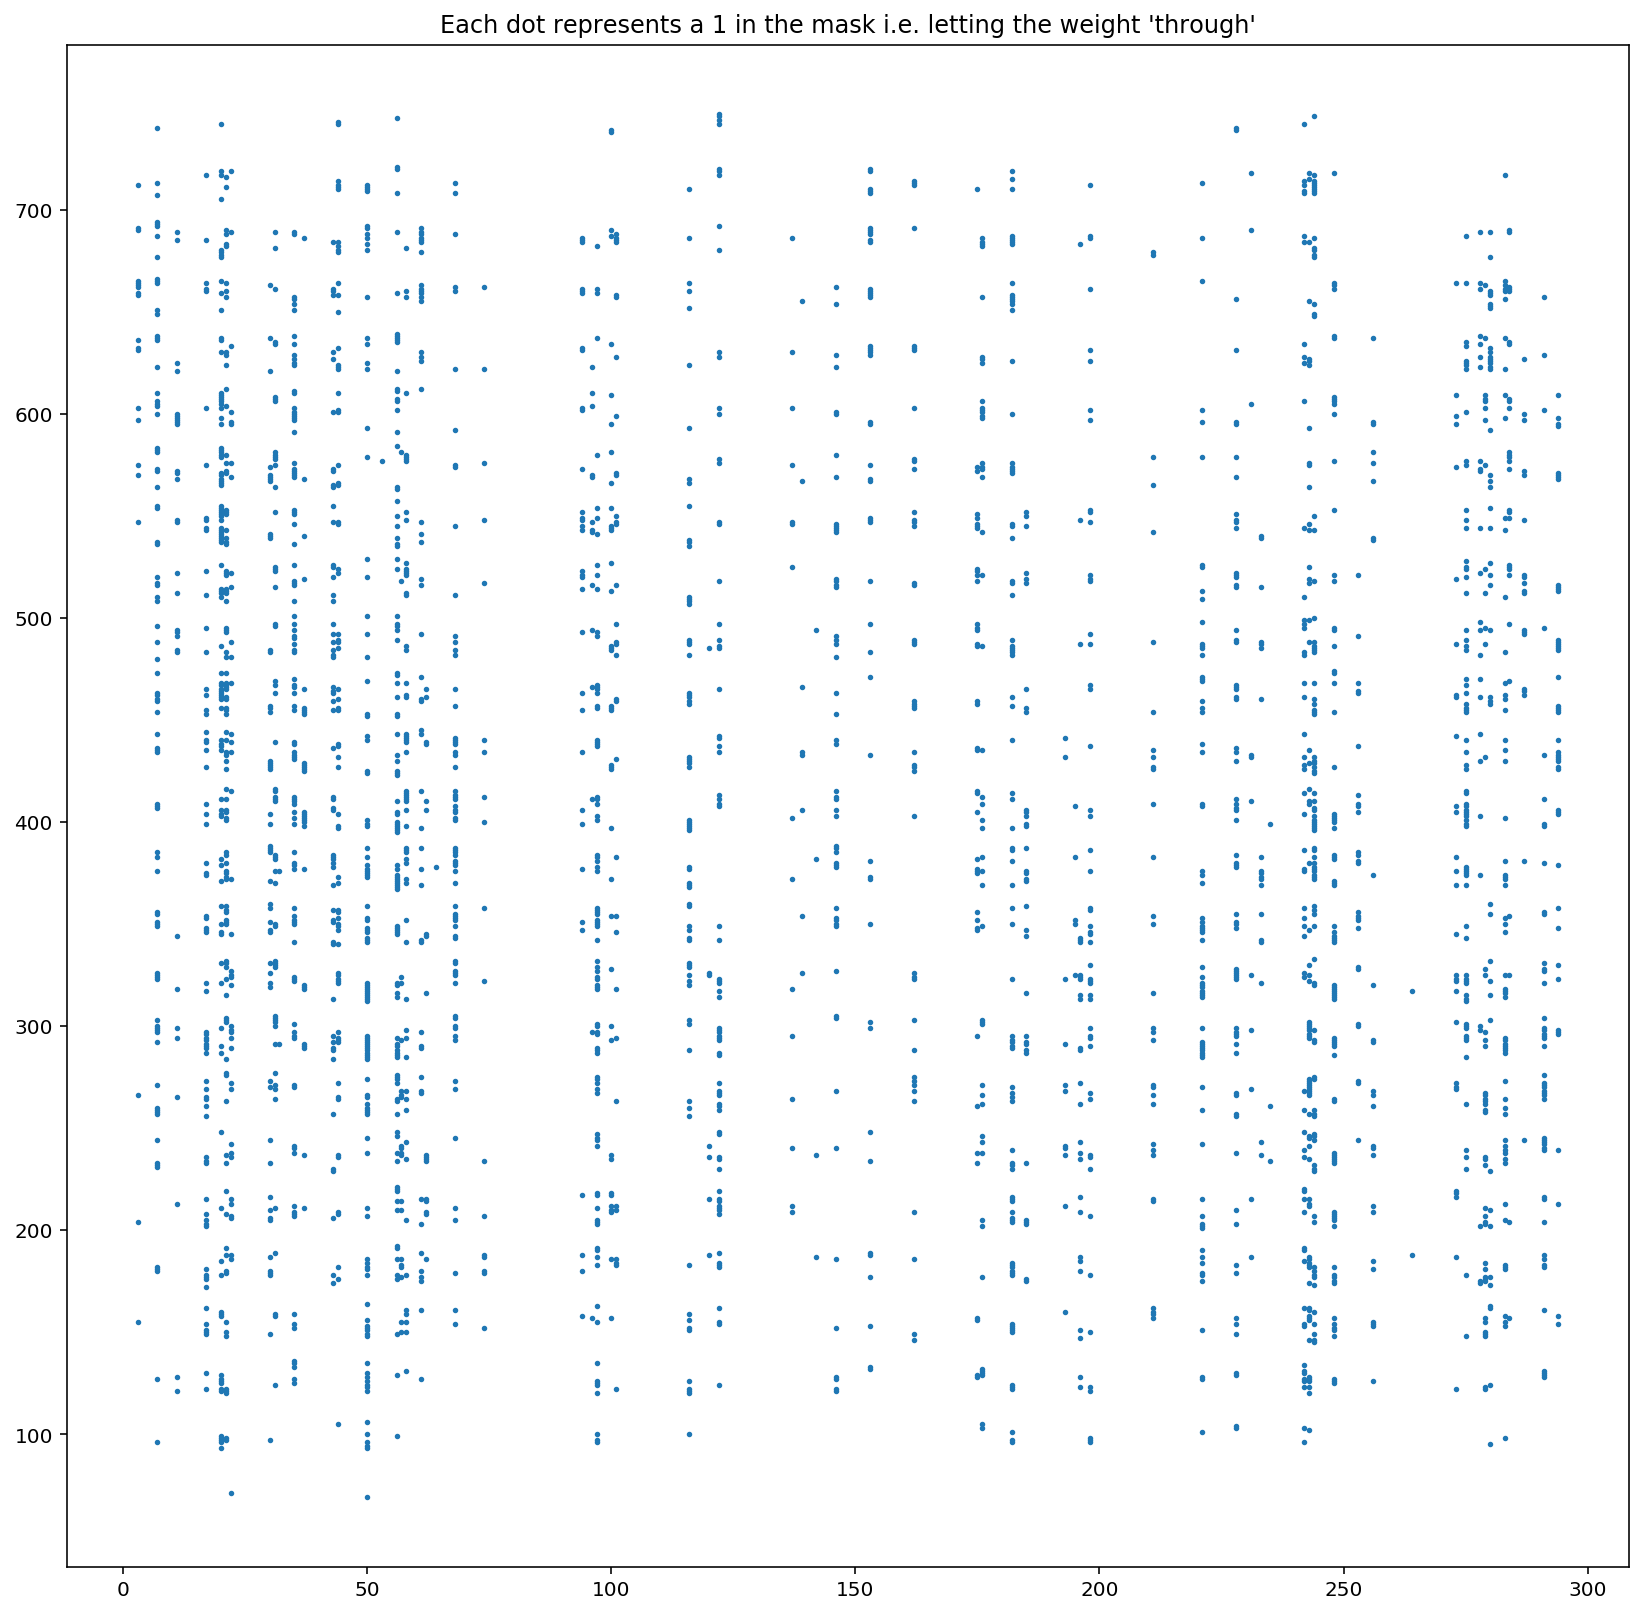

In [61]:
plt.figure(figsize=(14,14))
plt.scatter(a[1], a[0], s=3)
plt.title("Each dot represents a 1 in the mask i.e. letting the weight 'through'")

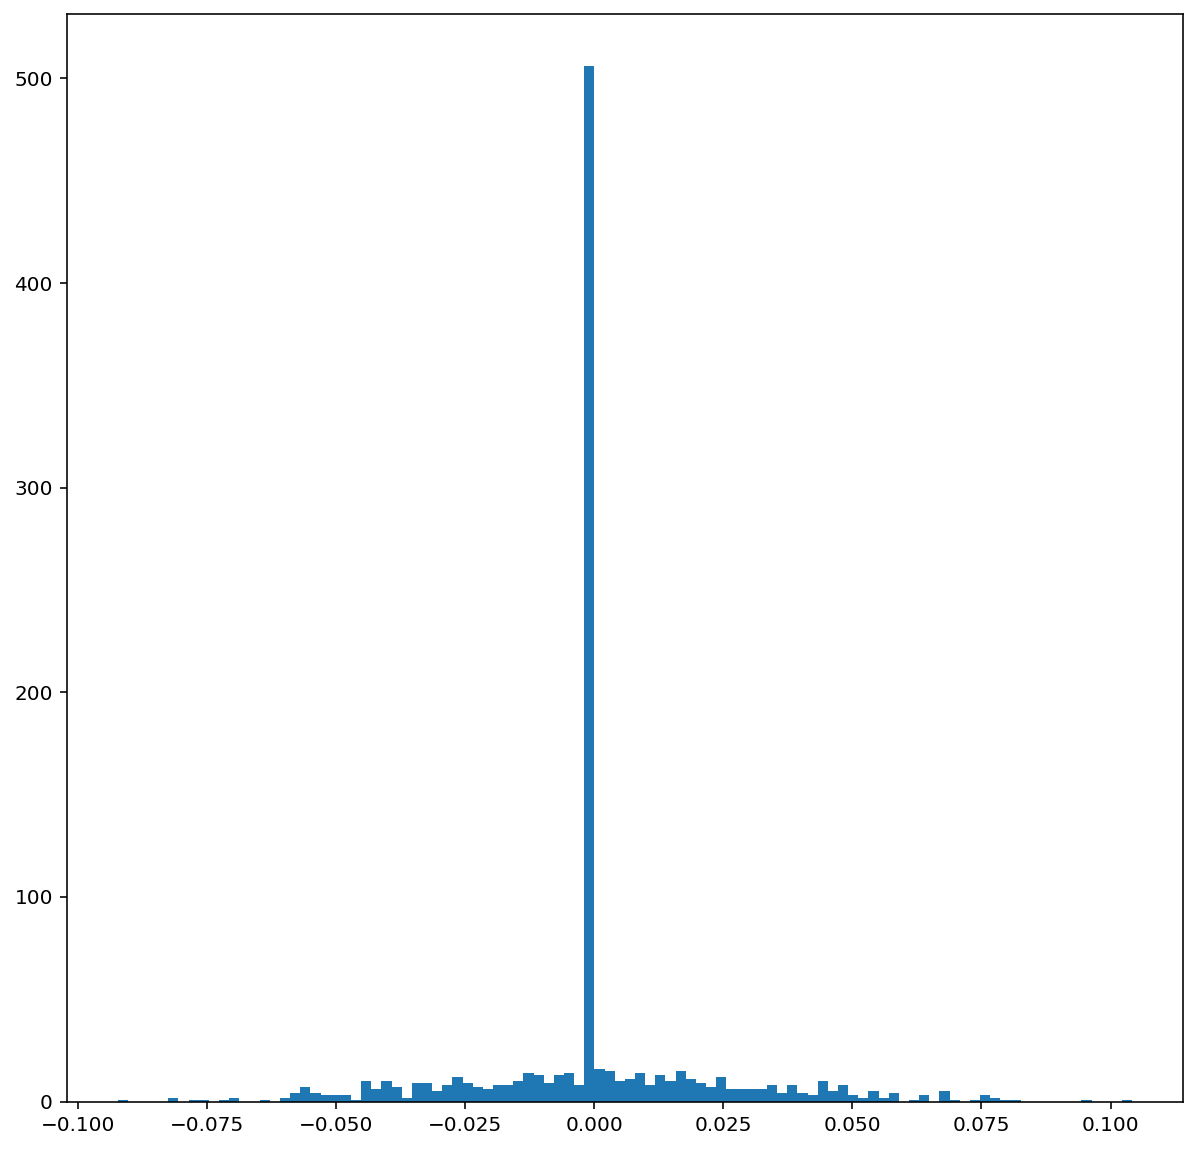

In [152]:
_ = plt.hist(fcn.layers[-1].get_pruned_weights().numpy().flatten(), bins=100)

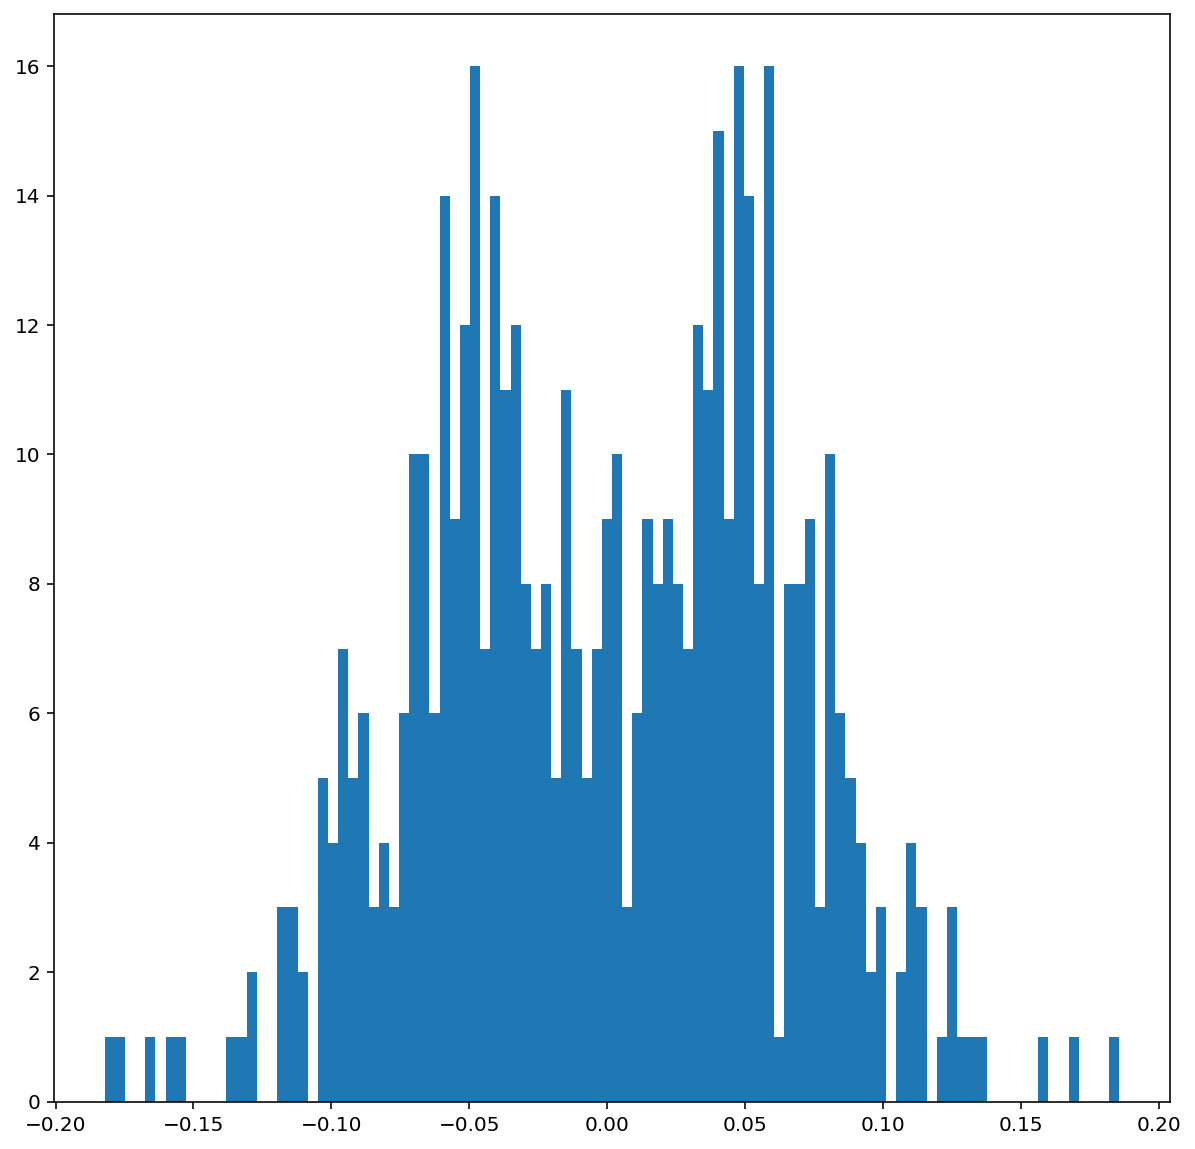

In [155]:
_ = plt.hist(fcn.layers[-1].get_nonzero_weights().numpy().flatten(), bins=100)

In [264]:
fcn.layers[0].get_nonzero_weights().numpy().flatten()[np.where(fcn.layers[0].get_nonzero_weights().numpy().flatten()<0)].mean()

-0.12859705

In [267]:
fcn.layers[0].get_nonzero_weights().numpy().flatten()[np.where(fcn.layers[0].get_nonzero_weights().numpy().flatten()<0)].std()

0.0346663

In [269]:
fcn.layers[0].get_nonzero_weights().numpy().flatten()[np.where(fcn.layers[0].get_nonzero_weights().numpy().flatten()>0)].mean()

0.12910517

In [278]:
np.where(fcn.layers[0].get_weights()[0] > 0)[0].shape

(306910,)

In [285]:
fcn.layers[0].get_weights()[0][np.where(fcn.layers[0].get_weights()[0] > 0)].shape

(306910,)

In [271]:
np.where(fcn.layers[0].get_nonzero_weights().numpy()>0)

(array([   2,    4,    5, ..., 4886, 4891, 4892], dtype=int64),)

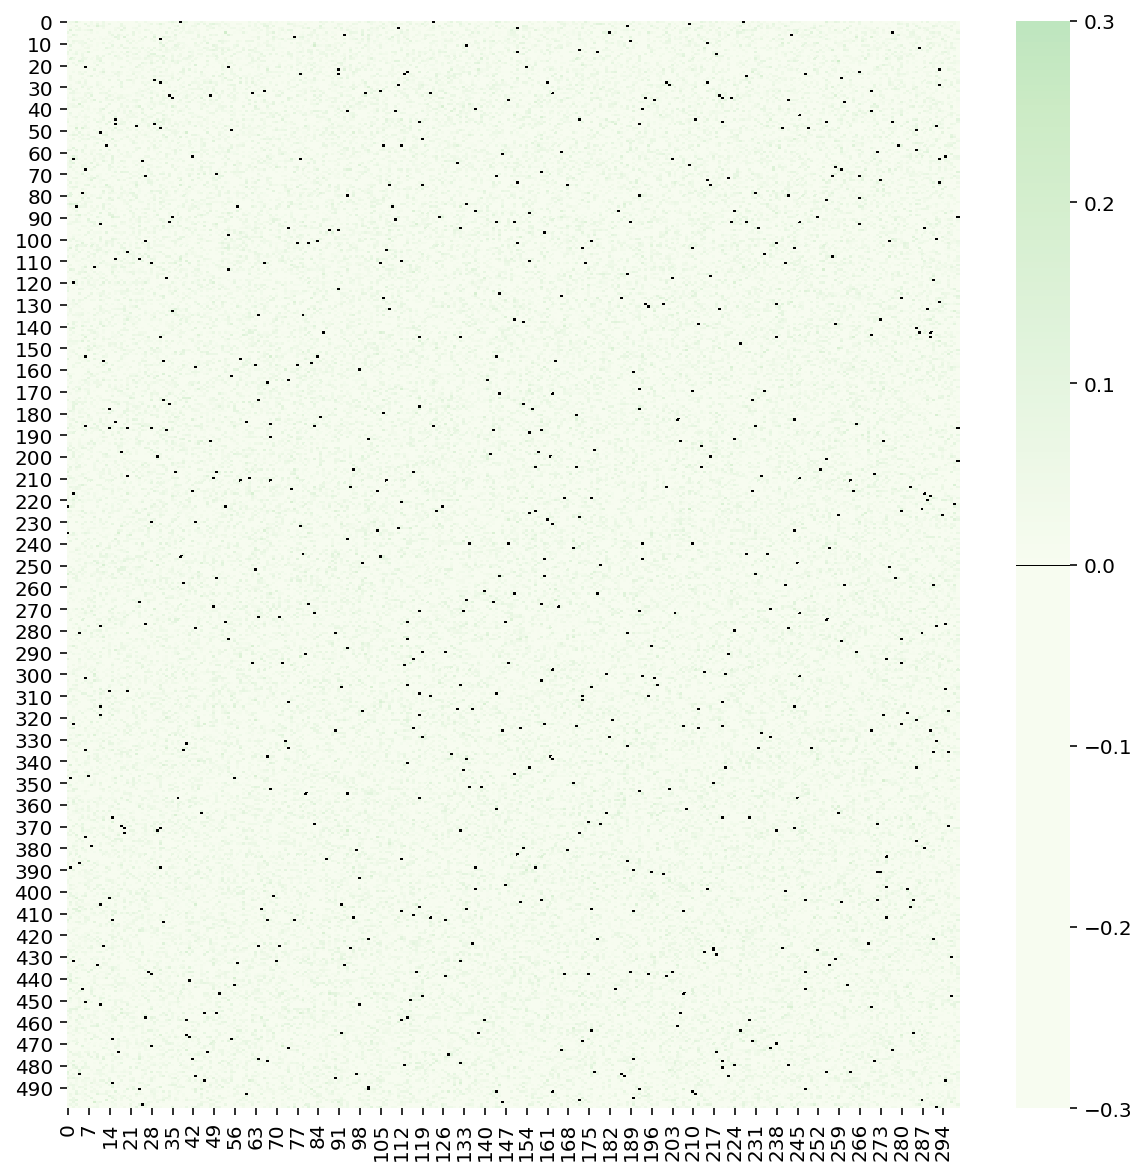

In [258]:
plt.figure(figsize=(10,10))
sns.heatmap(fcn.layers[2].get_weights()[0], cmap=cmap, vmin=-0.3, vmax=0.3)

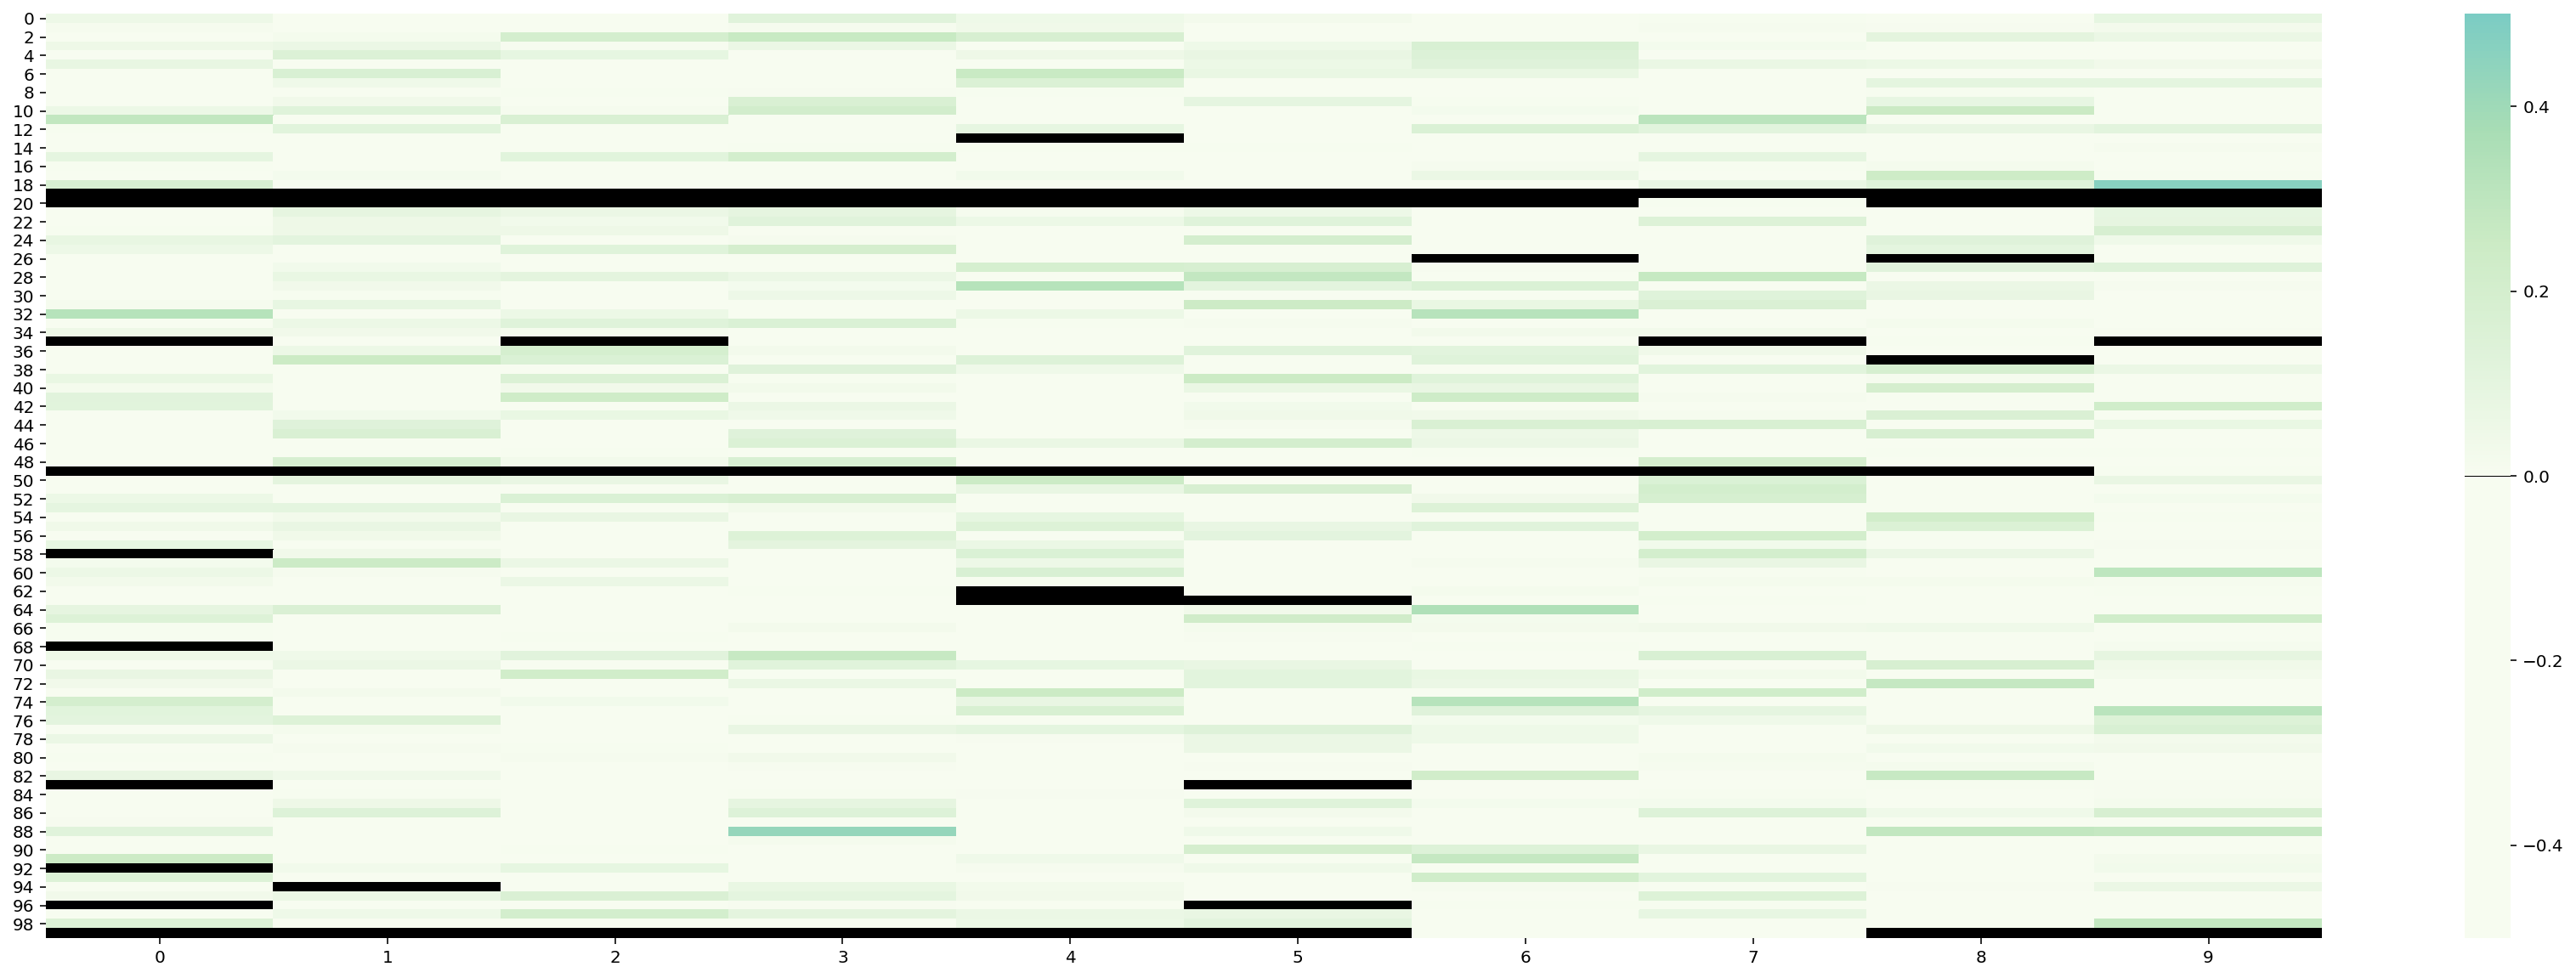

In [381]:
plt.figure(figsize=(30,10))
sns.heatmap(initial_weights[4][0] - fcn.layers[4].get_masked_weights(), cmap=cmap, vmin=-0.5, vmax=0.5)

In [111]:
len(a)

11

In [112]:
len(a[0])

5

In [113]:
len(b)

11

In [114]:
len(c)

11

In [77]:
len(a) == len(b)

False

In [69]:
[w[0].shape for w in initial_weights]

[(784, 784), (784, 500), (500, 300), (300, 100), (100, 10)]

In [239]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

In [240]:
loss_metric = tf.keras.metrics.Mean()
acc_metric = tf.keras.metrics.CategoricalAccuracy()

In [64]:
total_epochs = 0

In [241]:
def train_supermask_model(model, ds_train, epochs=6):
    optimizer = tf.keras.optimizers.SGD(learning_rate=100, momentum=0.9)
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    loss_metric = tf.keras.metrics.Mean()
    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    
    for epoch in range(epochs):
    
        print(f"Start of epoch {epoch}")

        # Iterate over the batches of the dataset.
        for step, (x_batch_train,y_batch_train) in enumerate(ds_train):
            with tf.GradientTape() as tape:
                predicted = model(x_batch_train)
                # Compute reconstruction loss
                loss = loss_fn(y_batch_train, predicted)


            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            loss_metric(loss)
            acc_metric(y_batch_train,predicted)

        print('Accuracy = %s --- Mean loss = %s' % (acc_metric.result().numpy(),loss_metric.result().numpy()))
    
    return model

In [242]:
fcn.trainable_weights

[<tf.Variable 'Variable:0' shape=(784, 300) dtype=float32, numpy=
 array([[-0.0662735 , -0.05274171, -0.01149807, ..., -0.00276897,
          0.04850461, -0.03255804],
        [-0.09606247,  0.14997105,  0.08774649, ...,  0.05491622,
          0.0281404 ,  0.01494945],
        [ 0.01769535, -0.00035723,  0.07295722, ...,  0.0118088 ,
          0.10274259,  0.02193561],
        ...,
        [ 0.00200775, -0.06371327,  0.05218528, ...,  0.01119289,
         -0.02042217,  0.01979396],
        [-0.03274408, -0.05543614,  0.04478224, ...,  0.01741876,
          0.04809215, -0.03136925],
        [ 0.0166466 , -0.04189679,  0.01401569, ..., -0.01747747,
         -0.00415009, -0.02411764]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(300, 100) dtype=float32, numpy=
 array([[ 0.02168435,  0.09734727, -0.01200359, ...,  0.0810706 ,
          0.00107519, -0.0320728 ],
        [ 0.05722294, -0.04819513, -0.0661897 , ..., -0.02154094,
          0.00678509, -0.01956631],
        [ 0.01410884,

In [243]:
fcn_mask = train_supermask_model(fcn, ds_train_mnist, epochs=100)

Start of epoch 0
Accuracy = 0.1329 --- Mean loss = 2.29774
Start of epoch 1
Accuracy = 0.1329 --- Mean loss = 2.297739
Start of epoch 2
Accuracy = 0.1329 --- Mean loss = 2.2977405
Start of epoch 3
Accuracy = 0.1329 --- Mean loss = 2.297739
Start of epoch 4
Accuracy = 0.1329 --- Mean loss = 2.2977364
Start of epoch 5
Accuracy = 0.1329 --- Mean loss = 2.2977364
Start of epoch 6
Accuracy = 0.1329 --- Mean loss = 2.2977371
Start of epoch 7
Accuracy = 0.1329 --- Mean loss = 2.2977383
Start of epoch 8
Accuracy = 0.1329 --- Mean loss = 2.2977364
Start of epoch 9
Accuracy = 0.1329 --- Mean loss = 2.2977374
Start of epoch 10
Accuracy = 0.1329 --- Mean loss = 2.297736
Start of epoch 11
Accuracy = 0.1329 --- Mean loss = 2.2977366
Start of epoch 12
Accuracy = 0.1329 --- Mean loss = 2.2977395
Start of epoch 13
Accuracy = 0.1329 --- Mean loss = 2.2977407
Start of epoch 14
Accuracy = 0.1329 --- Mean loss = 2.2977412
Start of epoch 15
Accuracy = 0.1329 --- Mean loss = 2.2977383
Start of epoch 16
Accur

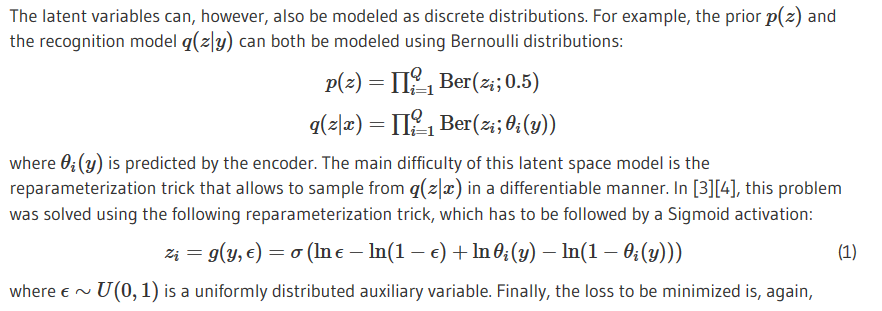

In [244]:
eps = np.random.uniform()

In [247]:
np.log(eps) - np.log(1-eps) + np.log(0.4) - np.log(0.6)

-0.9637210876489555

In [246]:
tf.math.sigmoid(np.log(eps) - np.log(1-eps) + np.log(0.4) - np.log(0.6))

<tf.Tensor: shape=(), dtype=float64, numpy=0.27613379004005545>

In [33]:
def just_train(model, ds_train, epochs=6):
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    loss_metric = tf.keras.metrics.Mean()
    acc_metric = tf.keras.metrics.CategoricalAccuracy()
    
    for epoch in range(epochs):
    
        print(f"Start of epoch {epoch}")

        # Iterate over the batches of the dataset.
        for step, (x_batch_train,y_batch_train) in enumerate(ds_train):
            with tf.GradientTape() as tape:
                predicted = model(x_batch_train)
                # Compute reconstruction loss
                loss = loss_fn(y_batch_train, predicted)


            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            loss_metric(loss)
            acc_metric(y_batch_train,predicted)

        print('Accuracy = %s --- Mean loss = %s' % (acc_metric.result().numpy(),loss_metric.result().numpy()))
    
    return model

In [34]:
fcn = just_train(fcn, ds_train_mnist, epochs=20)

Start of epoch 0
Accuracy = 0.27358332 --- Mean loss = 1.984207
Start of epoch 1
Accuracy = 0.5562 --- Mean loss = 1.2609708
Start of epoch 2
Accuracy = 0.6724278 --- Mean loss = 0.9501673
Start of epoch 3
Accuracy = 0.7372583 --- Mean loss = 0.772104
Start of epoch 4
Accuracy = 0.7791467 --- Mean loss = 0.65470976
Start of epoch 5
Accuracy = 0.808775 --- Mean loss = 0.5706227
Start of epoch 6
Accuracy = 0.8309524 --- Mean loss = 0.50698465
Start of epoch 7
Accuracy = 0.8482354 --- Mean loss = 0.45691052
Start of epoch 8
Accuracy = 0.86216295 --- Mean loss = 0.41632563
Start of epoch 9
Accuracy = 0.87361336 --- Mean loss = 0.38286564
Start of epoch 10
Accuracy = 0.8832485 --- Mean loss = 0.35454318
Start of epoch 11
Accuracy = 0.8914458 --- Mean loss = 0.33028978
Start of epoch 12
Accuracy = 0.8985346 --- Mean loss = 0.3092547
Start of epoch 13
Accuracy = 0.9047667 --- Mean loss = 0.2907444
Start of epoch 14
Accuracy = 0.9102378 --- Mean loss = 0.27436733
Start of epoch 15
Accuracy = 0

In [71]:
epochs = 5
#all_weights = [] #+ [w[0] for w in initial_weights]
#all_weights_pruned = []
#all_weights_nonzero = []
#all_weights.append([w[0] for w in initial_weights])
#all_weights_pruned.append([l.get_masked_weights().numpy() for l in fcn.layers])
#all_weights_nonzero.append([l.get_nonzero_weights().numpy() for l in fcn.layers])

# Iterate over epochs.
for epoch in range(epochs):
    
    print(f"Start of epoch {epoch}  ---  Total Epochs: {total_epochs}")
    total_epochs += 1
    # Iterate over the batches of the dataset.
    for step, (x_batch_train,y_batch_train) in enumerate(ds_train):
        with tf.GradientTape() as tape:
            predicted = smaller_fcn(x_batch_train)
            # Compute reconstruction loss
            loss = loss_fn(y_batch_train, predicted)
            #loss += sum(fcn.losses)
        
        grads = tape.gradient(loss, smaller_fcn.trainable_weights)
        optimizer.apply_gradients(zip(grads, smaller_fcn.trainable_weights))

        loss_metric(loss)
        acc_metric(y_batch_train,predicted)
        
        #if step % 100 == 0:
#    all_weights.append([w.numpy() for w in fcn.trainable_weights[::2]])
#    all_weights_pruned.append([l.get_masked_weights().numpy() for l in fcn.layers])
#    all_weights_nonzero.append([l.get_nonzero_weights().numpy() for l in fcn.layers])

    print('Accuracy = %s --- Mean loss = %s' % (acc_metric.result().numpy(),loss_metric.result().numpy()))

            

Start of epoch 0  ---  Total Epochs: 7
Accuracy = 0.96122223 --- Mean loss = 0.12937342
Start of epoch 1  ---  Total Epochs: 8
Accuracy = 0.9651333 --- Mean loss = 0.11673256
Start of epoch 2  ---  Total Epochs: 9
Accuracy = 0.9683667 --- Mean loss = 0.1062251
Start of epoch 3  ---  Total Epochs: 10
Accuracy = 0.9710926 --- Mean loss = 0.0973739
Start of epoch 4  ---  Total Epochs: 11
Accuracy = 0.97346336 --- Mean loss = 0.08970858


In [177]:
[len(w) for w in all_weights]

[5, 5, 5, 5, 5, 5]

In [58]:
def just_eval(model, ds_test):
    eval_acc = tf.keras.metrics.CategoricalAccuracy()
    eval_loss_mean = tf.keras.metrics.Mean()
    for x_batch_test, y_batch_test in ds_test:
        eval_pred = model(x_batch_test)
        eval_loss = loss_fn(y_batch_test, eval_pred)

        eval_loss_mean(eval_loss)
        eval_acc(y_batch_test, eval_pred)

    print(f"Evaluation Loss: {eval_loss_mean.result().numpy()}")
    print(f"Evaluation Accuracy: {eval_acc.result().numpy()}")

In [62]:
just_eval(fcn, ds_test_mnist)

Evaluation Loss: 2.292524814605713
Evaluation Accuracy: 0.8468000292778015


In [61]:
just_eval(fcn_small_new, ds_test)

NameError: name 'fcn_small_new' is not defined

In [81]:
new_shape = [[784, 403], [403, 226], [226, 76], [76, 10]]
fcn_small_new = FCN(input_dim, no_layers=NO_LAYERS, layer_shapes=new_shape)

In [93]:
just_train(fcn, ds_train_mnist_sm, epochs=10)

Start of epoch 0
Accuracy = 0.9474583 --- Mean loss = 0.16895945
Start of epoch 1
Accuracy = 0.9483125 --- Mean loss = 0.16594712
Start of epoch 2
Accuracy = 0.94904166 --- Mean loss = 0.16323392
Start of epoch 3
Accuracy = 0.9498906 --- Mean loss = 0.16070354
Start of epoch 4
Accuracy = 0.9506458 --- Mean loss = 0.15831774
Start of epoch 5
Accuracy = 0.95134026 --- Mean loss = 0.15612124
Start of epoch 6
Accuracy = 0.9519405 --- Mean loss = 0.15402275
Start of epoch 7
Accuracy = 0.952487 --- Mean loss = 0.15207976
Start of epoch 8
Accuracy = 0.9530509 --- Mean loss = 0.15022907
Start of epoch 9
Accuracy = 0.95357084 --- Mean loss = 0.14849071


In [52]:
tf.math.reduce_std(iter(ds_train_mnist).next()[0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.30320156>

In [35]:
fcn = FCN(input_dim, no_layers=NO_LAYERS, layer_shapes=LAYER_SHAPES)
SIGMA = -1#0.03
fcn, initial_weights = init.set_weights_man(fcn, mode="normal", mu=MU, sigma=SIGMA, mu_bi=MU_BI, sigma_bi=SIGMA_BI, save_to="./weights/initial_weights")    

Glorot normal with sigma 0.0018
Glorot normal with sigma 0.0050
Glorot normal with sigma 0.0182


In [36]:
optimizer_adam = tf.keras.optimizers.Adam(1.2e-3)
optimizer_sgd = tf.keras.optimizers.SGD(learning_rate=0.8, momentum=False)
optimizer_sgd_momentum = tf.keras.optimizers.SGD(learning_rate=5e-2, momentum=0.9)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

In [37]:
loss_metric = tf.keras.metrics.Mean()
acc_metric = tf.keras.metrics.CategoricalAccuracy()

In [49]:
ip = iterative_pruning(test, loss_fn = loss_fn, optimizer = optimizer)

NameError: name 'test' is not defined

In [38]:
ip = iterative_pruning(initial_weights, loss_fn = loss_fn, optimizer = optimizer_adam)

In [310]:
#fcn = ip.burn_in(fcn, dataset_train=ds_train, epochs=15, logging=True)

**Try doing the delta_high-pruning not with masked_weights but with all weights. Also check if the same weights get pruned away --> consistency?**

In [ ]:
for layer in smaller_fcn.layers:
    print(layer.mask.shape)
    layer.get_masked_weights()

In [102]:
[a[0].shape for a in initial_weights]

[(784, 300), (300, 100), (100, 10)]

In [39]:
#model, dataset, iterations, epochs, pruning_method="global", pruning_th=0.2, logging=True
fcn = ip.start(fcn, dataset_train=ds_train_mnist, iterations=6, epochs=10, dataset_test=ds_test_mnist, pruning_scope="global", pruning_method="delta_high_same_sign", pruning_th=0.3, logging=True, mask_1_action="re_init") #, prune_neurons=False, prune_neuron_iterations=3, keep_input=True,
latest_weights = fcn.get_weights()

--- Iteration 1/6 started ---
	-- Start of epoch 1/10 --
	Accuracy = 0.8621 --- Loss = 0.4569796
	-- Start of epoch 2/10 --
	Accuracy = 0.9063917 --- Loss = 0.31265807
	-- Start of epoch 3/10 --
	Accuracy = 0.9263667 --- Loss = 0.24610028
	-- Start of epoch 4/10 --
	Accuracy = 0.93868333 --- Loss = 0.20466489
	-- Start of epoch 5/10 --
	Accuracy = 0.9471167 --- Loss = 0.17614806
	-- Start of epoch 6/10 --
	Accuracy = 0.95351386 --- Loss = 0.15473956
	-- Start of epoch 7/10 --
	Accuracy = 0.9583976 --- Loss = 0.1381522
	-- Start of epoch 8/10 --
	Accuracy = 0.9624396 --- Loss = 0.12451583
	-- Start of epoch 9/10 --
	Accuracy = 0.96575 --- Loss = 0.11343114
	-- Start of epoch 10/10 --
	Accuracy = 0.968565 --- Loss = 0.10402512
Evaluate before applying a pruning step:
		Test Loss: 0.0814727321267128
		Test Accuracy: 0.9790999889373779
p-smallest value is (with -2): 0.022. This means, that weights did either not move more than this value or the weight itself is smaller than the value (afte

In [321]:
ip.mask_globally_delta_high(fcn, 0.2)

89.99% of the total weights are 0-masked i.e. they are smaller than the p_val


- Multiply input with mask
- Build network with weights and deleted neurons of pruned net

In [184]:
np.concatenate([w.numpy().flatten() for w in fcn.trainable_weights[::2]]).shape

(1057656,)

In [88]:
ip.evaluate(fcn, ds_test, single_mode=True)

		Test Loss: 0.7700110077857971
		Test Accuracy: 0.7162933349609375


The following weight arrays are built up as follows:
- Dimension 0: Iteration X
- Dimension 1: Epoch Y + Initialization 
- Dimension 3: Layer Z
- Dimension 4/5: Weights  

*Special Case: `weights_history[0]` contains the initialization weights and the length of Dimension 1 is therefore only 1*

In [100]:
#weights_history, self.weights_pruned_history, self.weights_nonzero_history
weights_history,weights_masked_history,weights_nonzero_history, weights_pruned_history, weights_delta_history = ip.get_weight_history()

In [48]:
len(weights_delta_history)

3

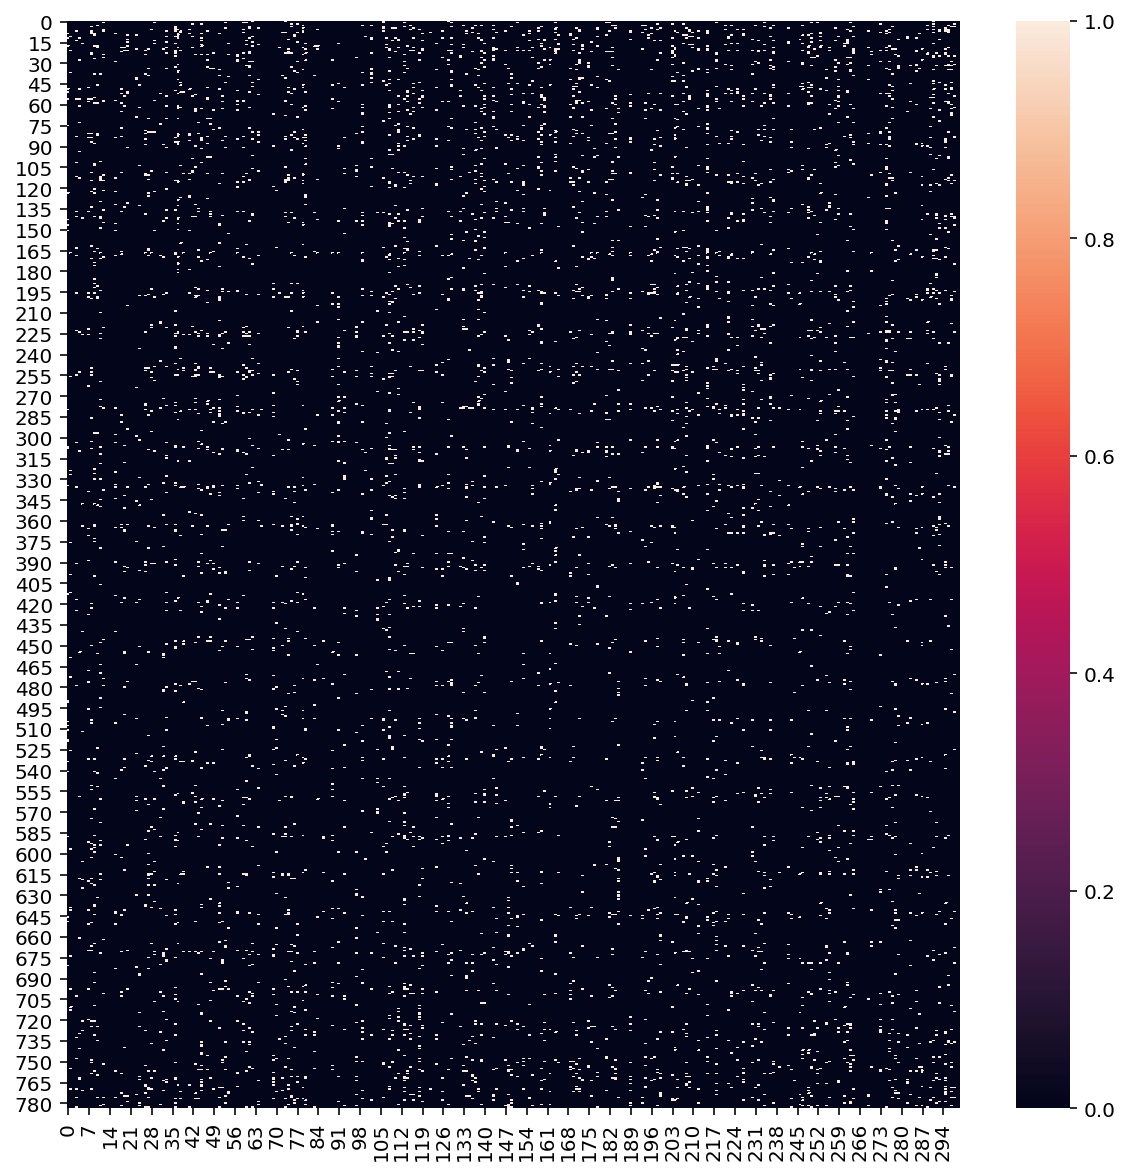

In [113]:
sns.heatmap(ip.mask_history[it][0])

In [65]:
b[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
        5,  5,  5,  5,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9, 10, 10, 10, 10, 10, 10,
       11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15,
       15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19,
       19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 22, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 30, 30, 30

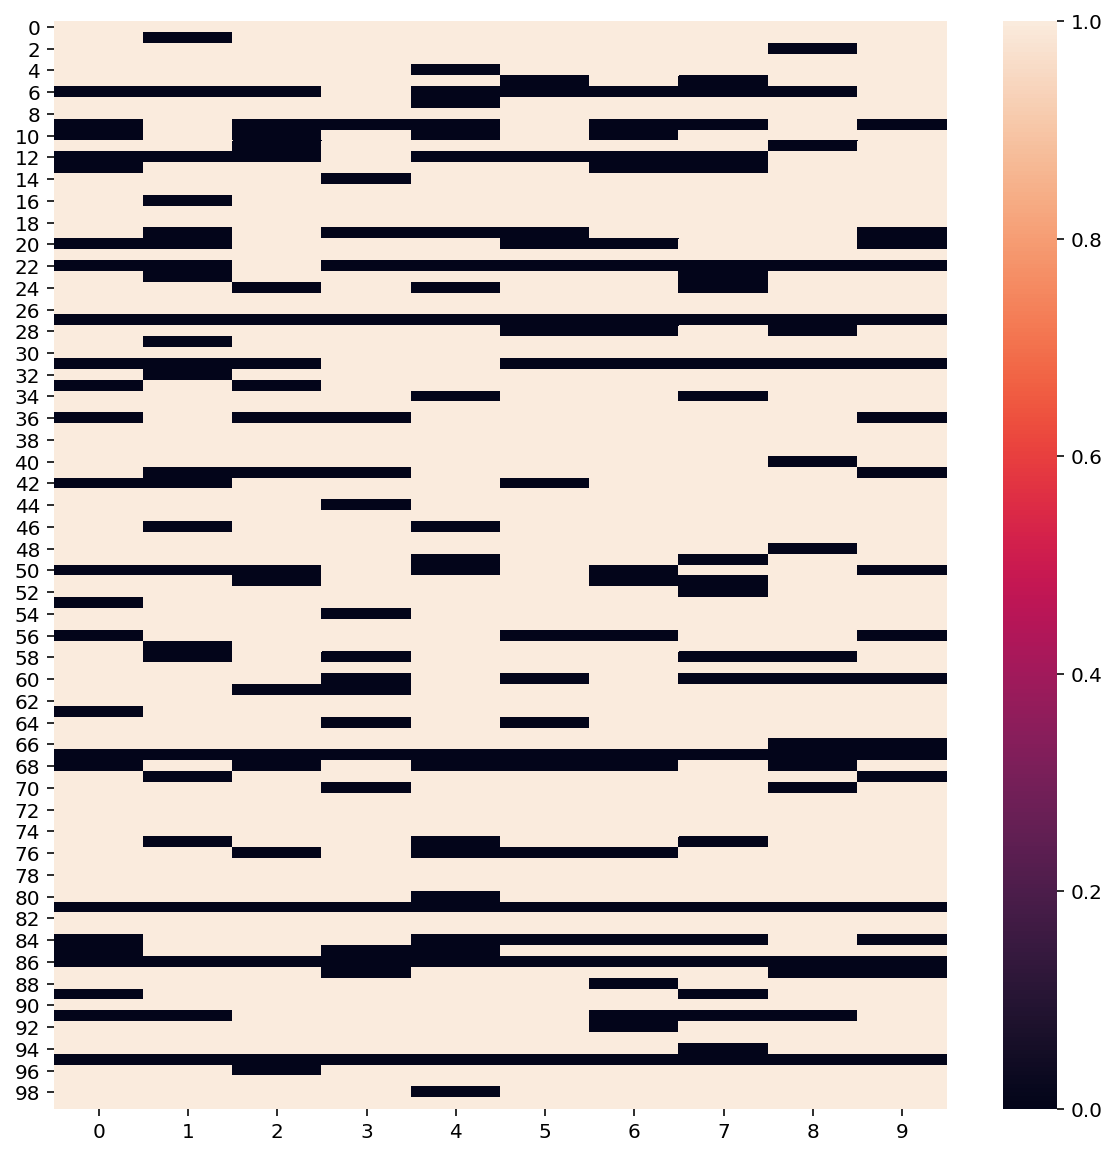

In [67]:
b = np.nonzero(ip.mask_history[it][layer])
sns.heatmap(ip.mask_history[it][layer])

In [36]:
t = ip.mask_history[1][0] - ip.mask_history[2][0]

In [110]:
t = ip.mask_history[1][0]

In [116]:
np.unique(t)

array([-1.,  0.,  1.], dtype=float32)

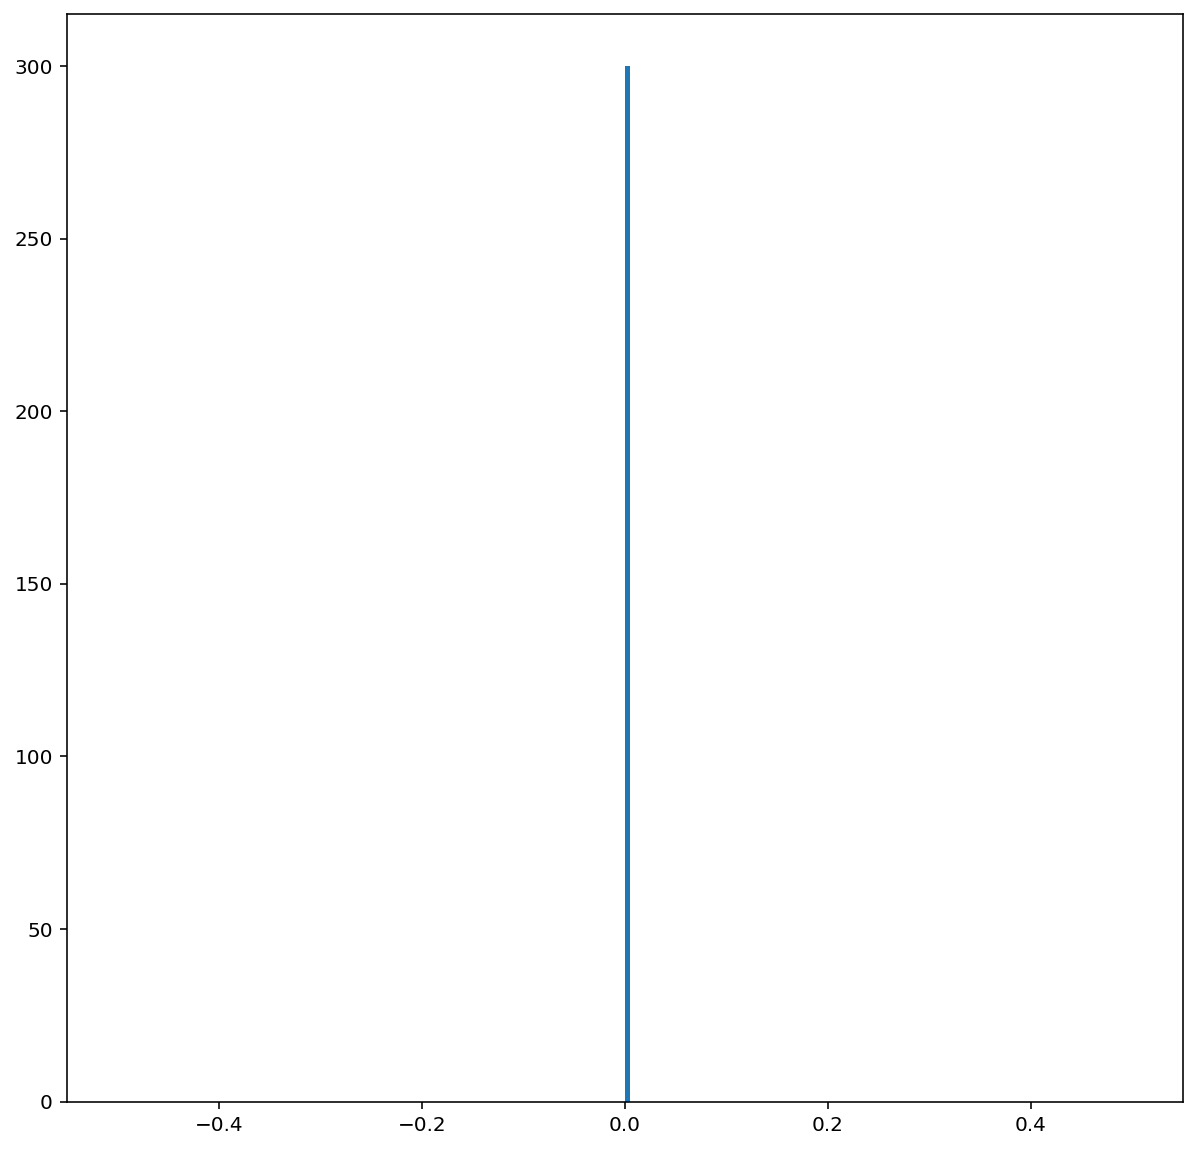

In [37]:
_ = plt.hist(fcn.layers[0].get_bias().numpy(), bins = 200)

In [40]:
fcn.layers[2].get_bias()

<tf.Variable 'Variable:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [42]:
_ = plt.hist(initial_weights[0][0][np.where(t == 1)], bins=200)

NameError: name 't' is not defined

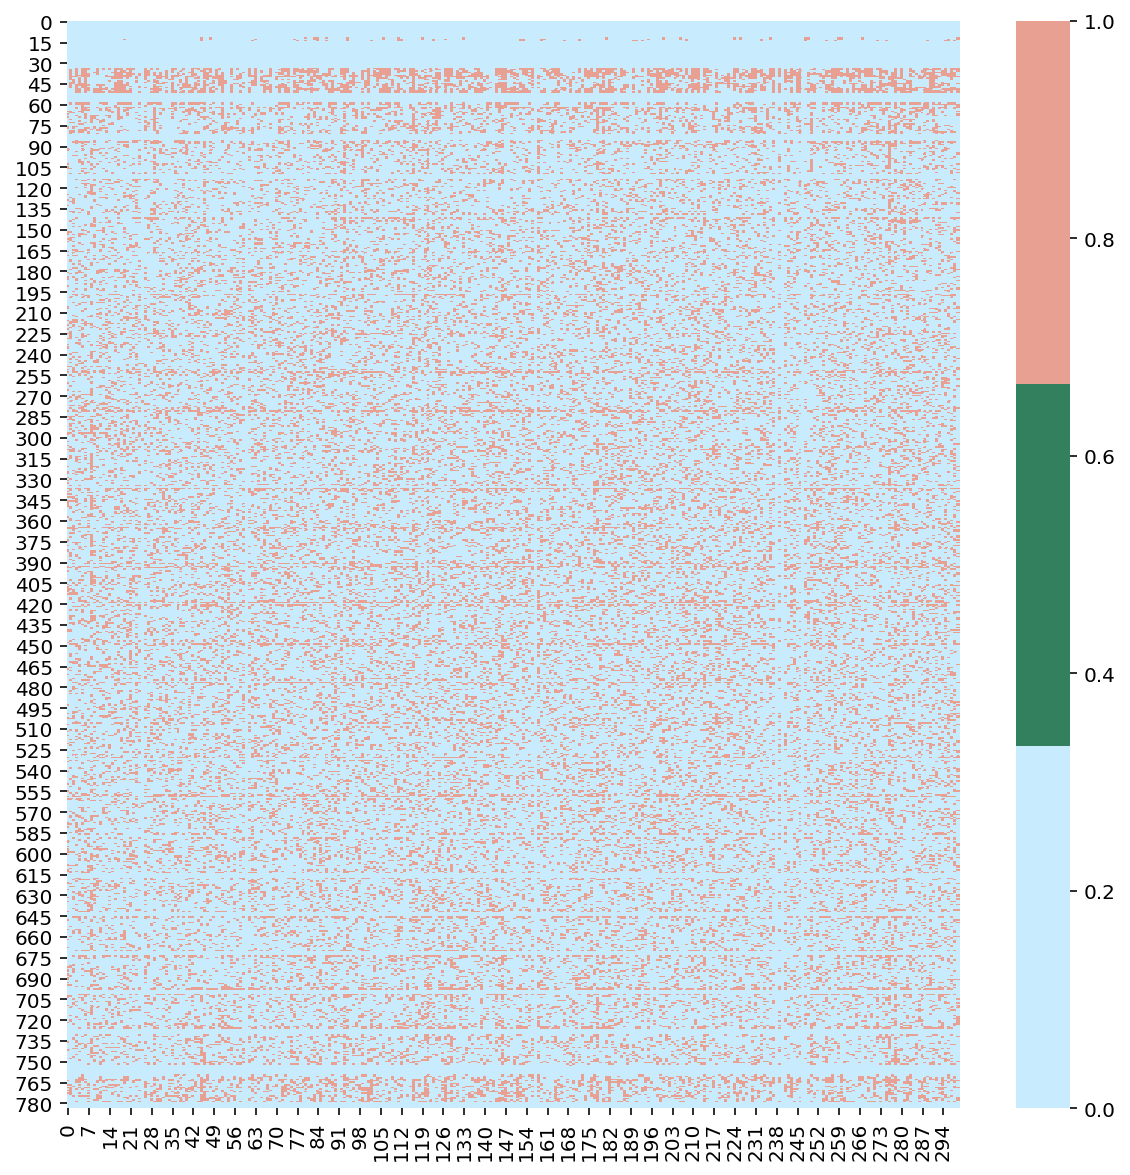

In [44]:
sns.heatmap(ip.mask_history[1][0] - ip.mask_history[2][0], cmap=["#C8EBFD", "#32805D", "#E8A092"])

In [80]:
np.unique(ip.mask_history[1][0])

array([0., 1.], dtype=float32)

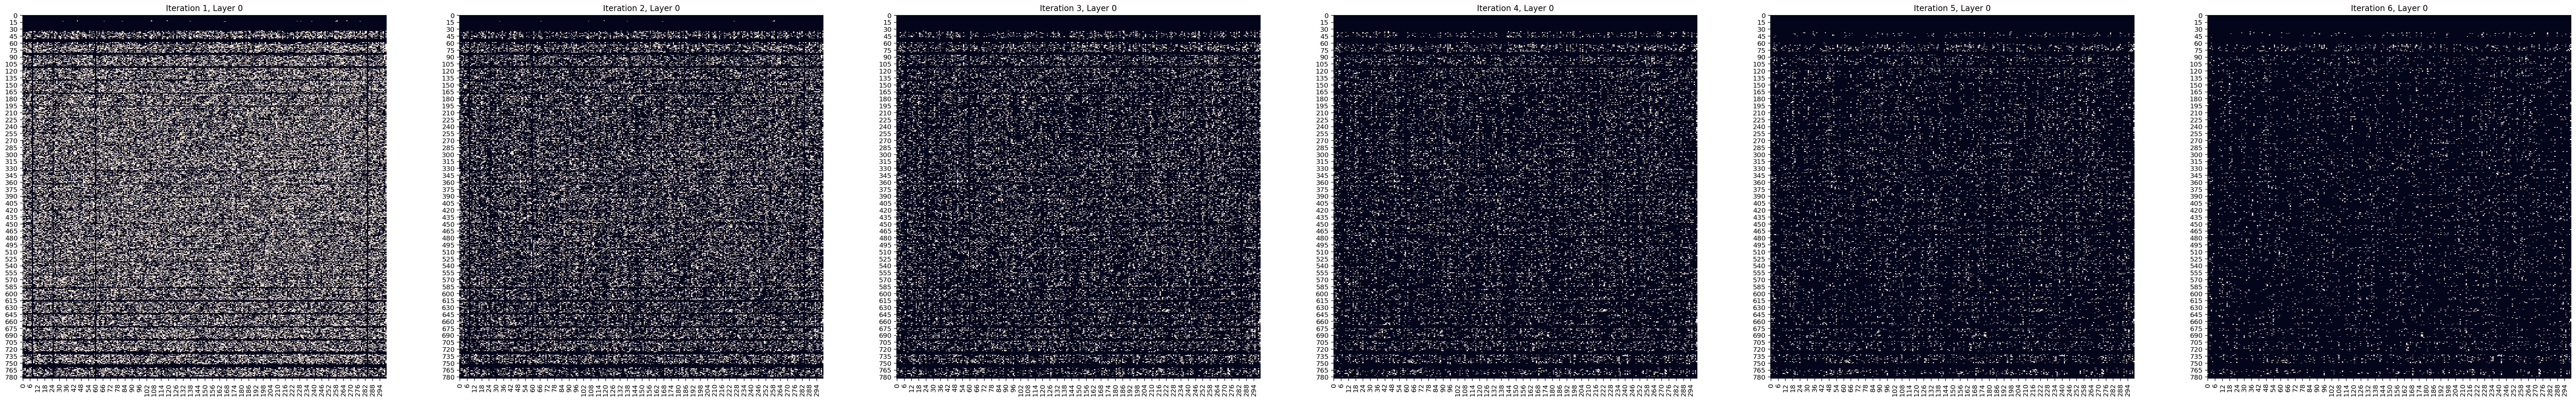

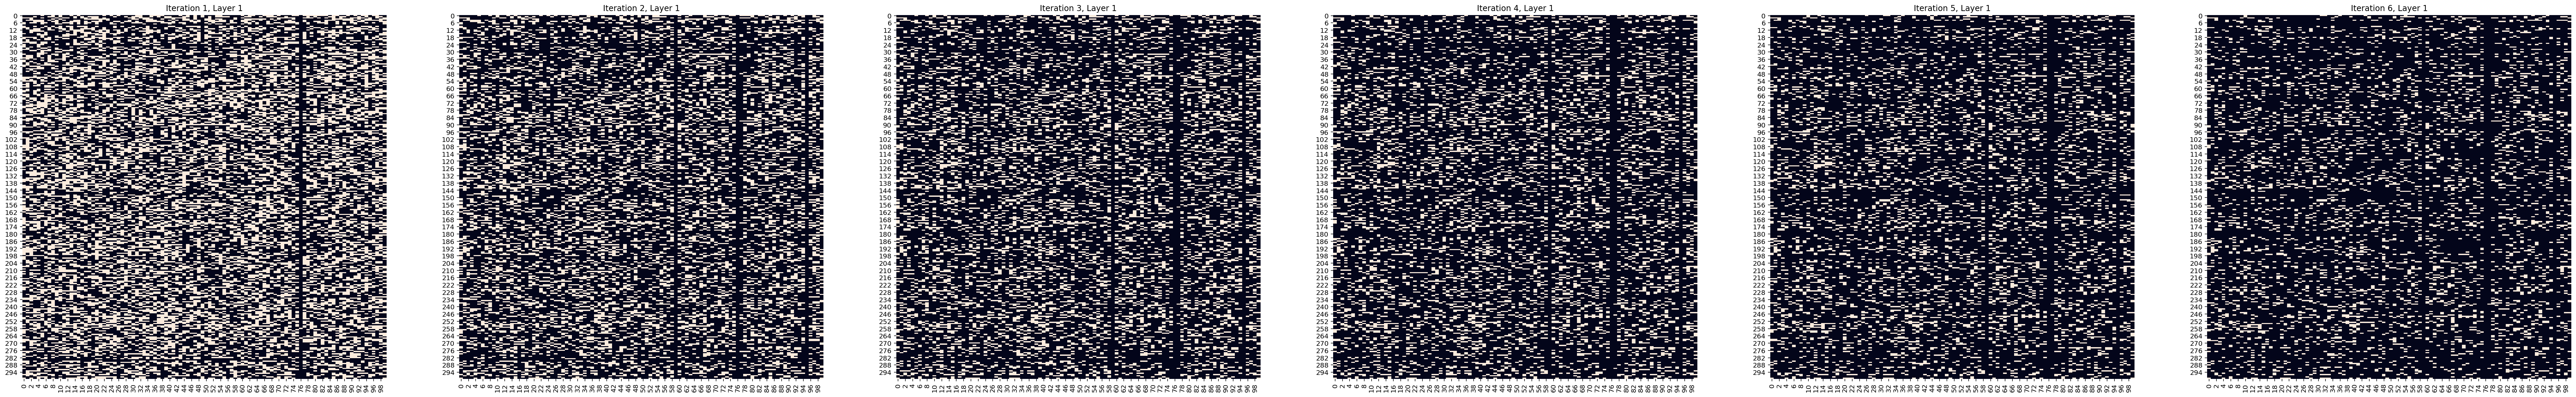

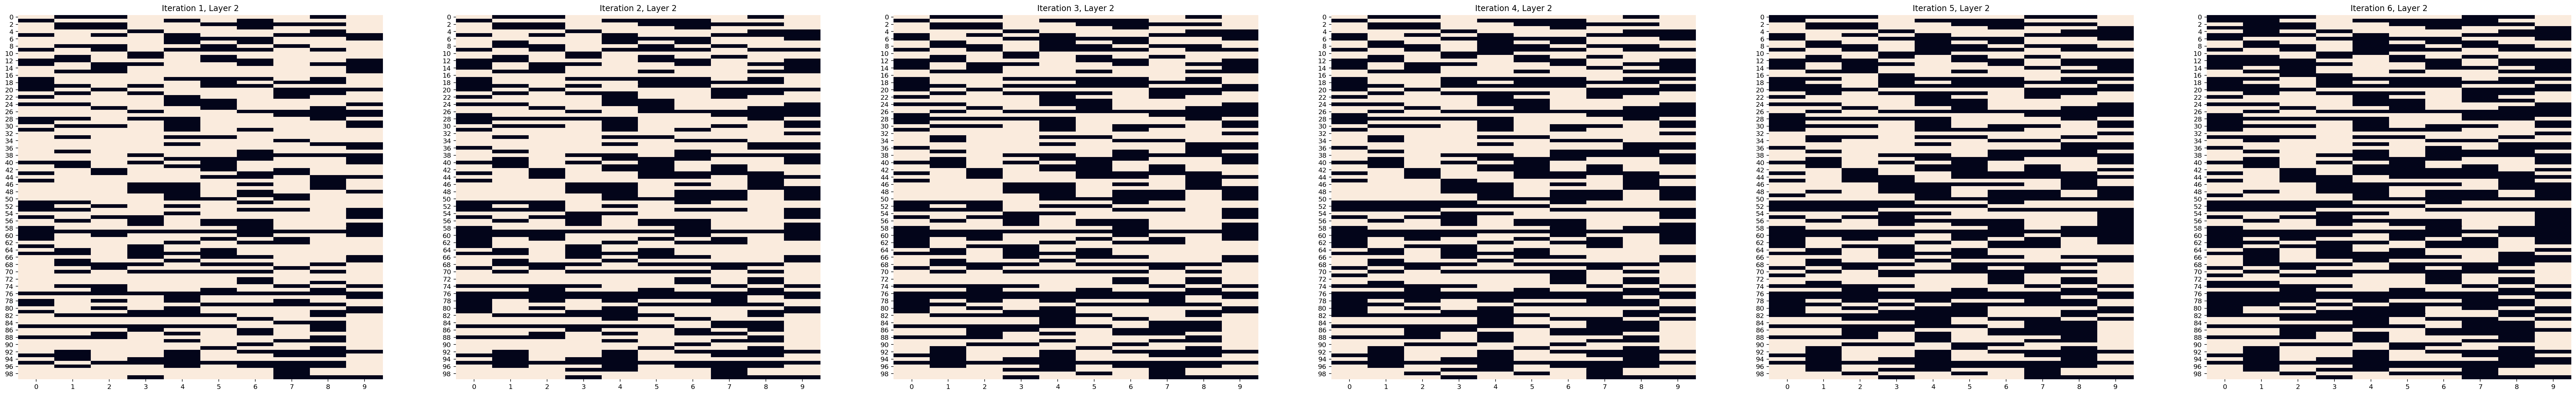

In [55]:
for layer in range(len(ip.mask_history[0])):
    plt.figure(figsize=(80,10))
    for it in range(len(ip.mask_history)):
        if it == 0:
            continue
        plt.subplot(1,len(ip.mask_history),it+1)
        mask = ip.mask_history[it][layer] #np.nonzero(ip.mask_history[it][layer])
        _ = sns.heatmap(mask, cbar=False)
        plt.title(f"Iteration {it}, Layer {layer}")

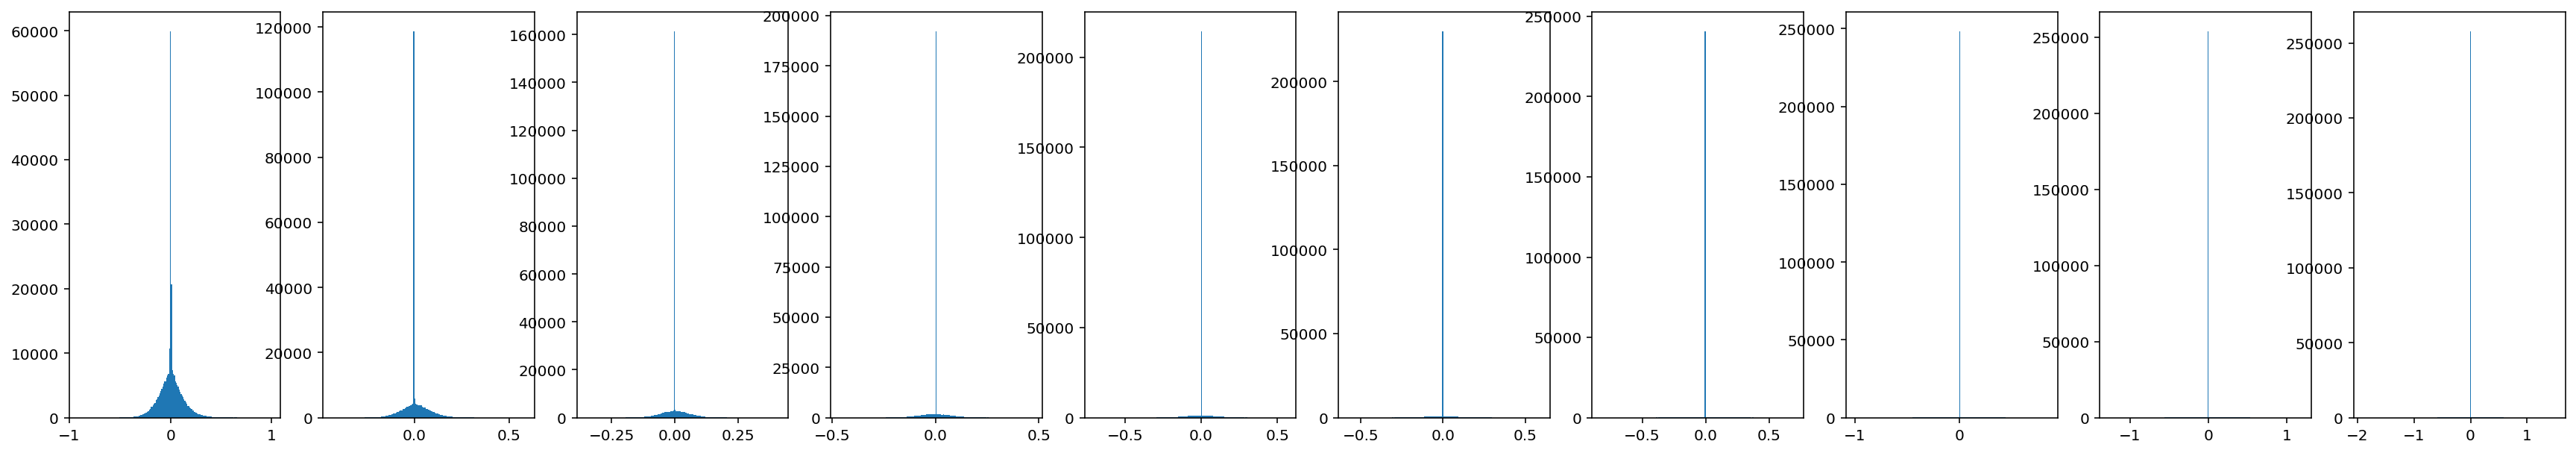

In [102]:
plt.figure(figsize=(30,5))
for i,delta in enumerate(weights_delta_history):
    plt.subplot(1,len(weights_delta_history),1+i)
    _ = plt.hist(delta, bins=200)

In [533]:
ip.dump_weight_history(path="./weights/all_weight_history.pkl")

In [57]:
len(weights_history[1][0])

5

In [59]:
weights_history[1][0][0].shape

(784, 784)

In [40]:
acc = ip.get_acc_history()

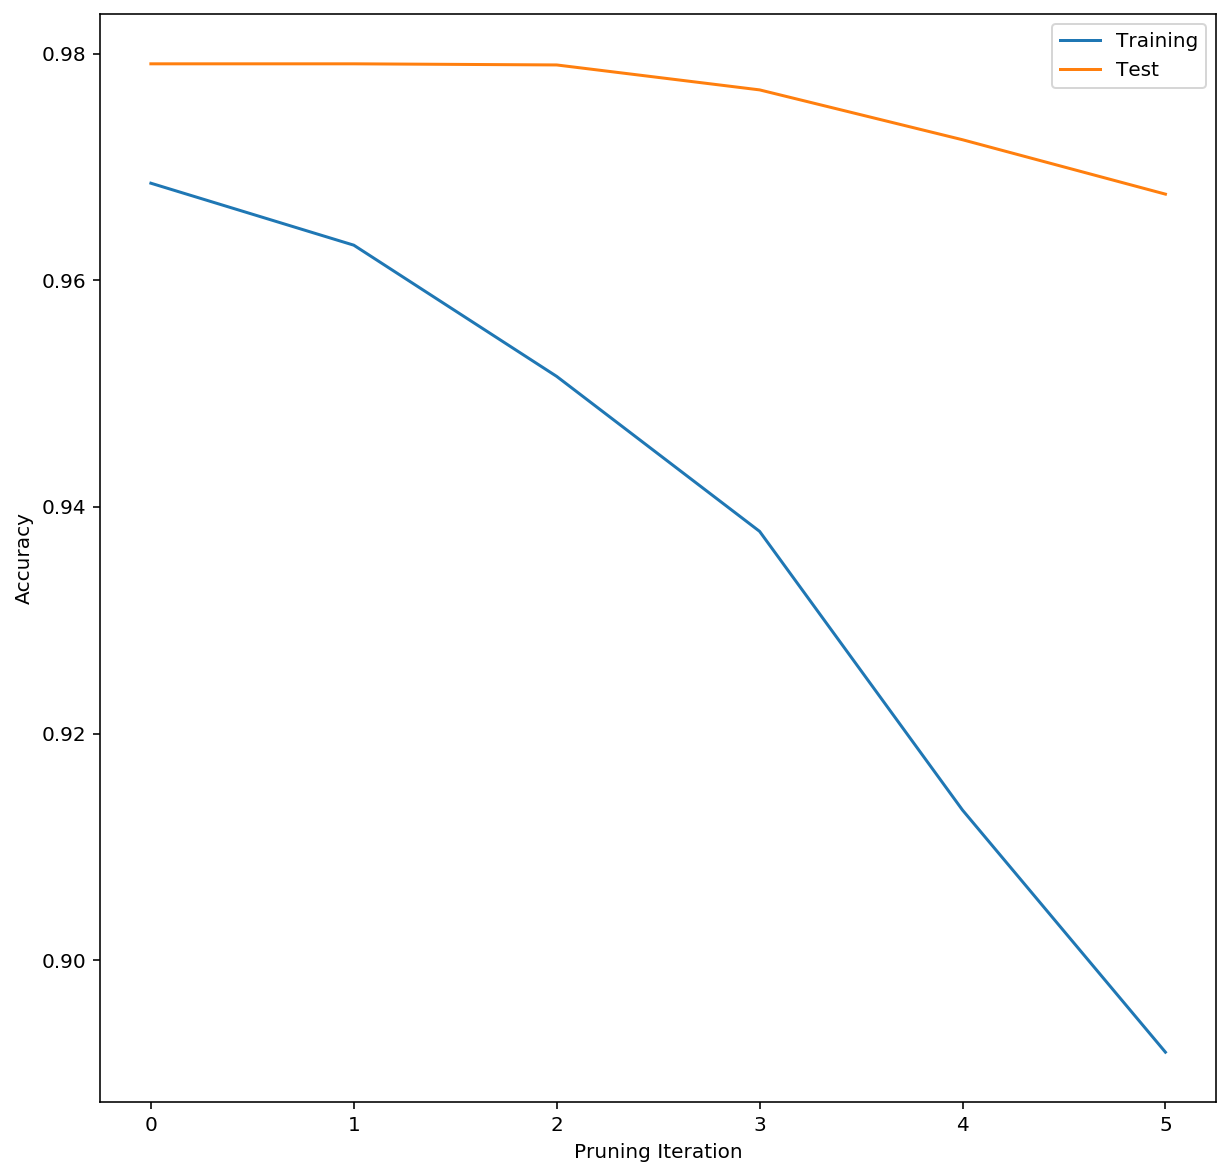

In [41]:
plt.plot(acc[0], label="Training")
plt.plot(acc[1], label="Test")
plt.xlabel("Pruning Iteration")
plt.ylabel("Accuracy")
plt.legend()

- Compare Initialization Methods
- Einheitliche Visualisierungen

In [142]:
for iw in ip.initial_weights:
    print(iw[0].shape)
    print(iw[1].shape)

(784, 784)
(784,)
(784, 500)
(500,)
(500, 300)
(300,)
(300, 100)
(100,)
(100, 10)
(10,)


In [294]:
def count_weights(model):
    return np.sum([l.count_params() - l.units for l in model.layers])

def count_masked_weights(model):
    return tf.reduce_sum([tf.math.count_nonzero(l.get_masked_weights()) for l in fcn.layers]).numpy()

def layerwise_pruning_p(model):
    for i,l in enumerate(model.layers):
        total = l.count_params() - l.units
        masked = tf.math.count_nonzero(l.get_masked_weights())
        print(f"{((total-masked)/total) * 100}% of Layer {i} weights are pruned")

In [295]:
layerwise_pruning_p(fcn)

96.1952701999167% of Layer 0 weights are pruned
94.41403061224489% of Layer 1 weights are pruned
85.332% of Layer 2 weights are pruned
83.6% of Layer 3 weights are pruned


In [297]:
(count_weights(fcn) - count_masked_weights(fcn)) / count_weights(fcn)

0.9500962505767471

In [301]:
1-0.4**3

0.9359999999999999

In [84]:
def get_margin_min_weights(weights, th=0.2):
    w_shape = weights.shape[0]
    #idx_weights_sorted = np.absolute(weights).argsort()
    weights_sorted = np.sort(np.absolute(weights))
    
    weights_sorted_zeros_idx = np.where(weights_sorted == 0.)[0]
    weights_sorted_nonzero_idx = np.where(weights_sorted != 0.)[0]
    
    #Array with argsort is sorted, so only the count of zero and non-zero indices is important. 
    #To maintain the same shape for every array, count of zeros is added on top of the pruning ratio
    
    return np.absolute(weights).argsort()[:int(weights_sorted_zeros_idx.shape[0] + weights_sorted_nonzero_idx.shape[0]*th)]

def get_margin_max_weights(weights, th=0.8):
    w_shape = weights.shape[0]
    return np.absolute(weights).argsort()[::-1][:int(w_shape*th)]

def get_p_smallest_value(weights, p, absolute=True):
    w_shape = weights.shape[0]

    if absolute:
        weights_sorted = np.sort(np.absolute(weights))
        weights_sorted_zeros_idx = np.where(weights_sorted == 0.)[0]
        weights_sorted_nonzero_idx = np.where(weights_sorted != 0.)[0]
        
        return np.sort(np.absolute(weights))[int(weights_sorted_zeros_idx.shape[0] + weights_sorted_nonzero_idx.shape[0]*p)]

In [85]:
def get_global_neuron_position(idx, model):
    no_layers = len(model.layers)
    no_neurons = [l.units for l in model.layers]
    # number of weights in a layer without bias
    no_weights = [l.count_params() - l.units for l in model.layers]
    print(no_neurons)
    total_no_weights = np.sum(no_neurons)
    return total_weights
    

In [86]:
def mask_layerwise(model, th=0.8, get_ones=True):
    for l in model.layers:
        weights_shape = l.get_masked_weights().shape
        weights_flat = l.get_masked_weights().numpy().flatten()
        
        old_mask = l.get_mask()

        if get_ones:
            mask = np.zeros(weights_shape)
            idx_mask_flat = get_margin_max_weights(weights_flat, th)
        else:
            mask = np.ones(weights_shape)
            idx_mask_flat = get_margin_min_weights(weights_flat, th)

        idx_mask_unrav = np.unravel_index(idx_mask_flat, weights_shape)
        idx_mask_orig = [list(i) for i in zip(idx_mask_unrav[0], idx_mask_unrav[1])]

        if get_ones:
            mask[idx_mask_unrav] = 1.
        else:
            mask[idx_mask_unrav] = 0.
        
        if get_ones:
            mask = np.logical_or(old_mask,mask).astype("float32")
        else:
            mask = np.logical_and(old_mask,mask).astype("float32")
        l.set_mask(mask)
    return model

In [251]:
fcn = mask_layerwise(fcn,th=0.2,get_ones=False)

In [89]:
def mask_globally(model, th=0.5):
    shape_info = [l.weights[0].shape for l in model.layers]
    all_weights_flat = np.concatenate([l.get_masked_weights().numpy().flatten() for l in model.layers])
    
    mask = np.ones(all_weights_flat.shape)
    
    p_val = get_p_smallest_value(all_weights_flat, p=th)
    print(p_val)
    all_weights_smaller_p = np.where(np.absolute(all_weights_flat) < p_val)[0]
    
    mask[all_weights_smaller_p] = 0
    
    for i,s in enumerate(shape_info):
        print(i,s)
        print("Mask shape: ", mask.shape)
        old_mask = model.layers[i].get_mask()
        layer_mask = mask[:s[0]*s[1]].reshape(s)
        layer_mask = np.logical_and(old_mask,layer_mask).astype("float32")
        print(layer_mask.shape)
        model.layers[i].set_mask(layer_mask)
        mask = mask[s[0]*s[1]:]
    
    return model

In [170]:
fcn = mask_globally(fcn, th=0.3)

0.048231676
0 (784, 784)
Mask shape:  (1187656,)
(784, 784)
1 (784, 500)
Mask shape:  (573000,)
(784, 500)
2 (500, 300)
Mask shape:  (181000,)
(500, 300)
3 (300, 100)
Mask shape:  (31000,)
(300, 100)
4 (100, 10)
Mask shape:  (1000,)
(100, 10)


In [156]:
def get_layer_neuron_position(original_shape, idx):
    row = flattened_shape // idx
    col = flattened_shape % idx
    return row,col

In [ ]:
get_layer_neuron_position()

In [75]:
count_weights(fcn)

1437656

In [70]:
get_neuron_position(1, fcn)

[614656, 392000, 250000, 150000, 30000, 1000]


1437656

In [33]:
np.absolute(all_weights_flat).argsort()[:3]

array([400413, 232210, 588631], dtype=int64)

In [34]:
all_weights_flat[np.absolute(all_weights_flat).argsort()[:3]]

array([8.0100790e-08, 1.3837587e-07, 2.1931491e-07], dtype=float32)

In [30]:
all_weights_flat[all_weights_flat.argsort()[:3]]#[::-1]

AttributeError: 'numpy.ndarray' object has no attribute 'absolute'

In [27]:
fcn.layers[0].variables[0].numpy().flatten().argsort()[:3]

array([340864, 230706, 340080], dtype=int64)

In [204]:
tf.math.argmax(fcn.predict(ds_test),axis=1).numpy()

array([8, 9, 9, ..., 8, 6, 3], dtype=int64)

In [31]:
fcn.weights[0]

<tf.Variable 'fcn/dense/kernel:0' shape=(784, 784) dtype=float32, numpy=
array([[ 0.00320148, -0.01827742,  0.06130352, ...,  0.04060205,
         0.02379157, -0.03781855],
       [ 0.00195461, -0.04731672,  0.02820133, ...,  0.01904944,
         0.0046684 , -0.0160788 ],
       [-0.04681788,  0.05586999,  0.01616797, ...,  0.04487784,
        -0.036598  ,  0.05946429],
       ...,
       [ 0.03616958,  0.05537617,  0.05029987, ..., -0.04570258,
        -0.04829326, -0.02737596],
       [ 0.02342445,  0.03788621, -0.04843409, ..., -0.00373795,
         0.05040981,  0.05115459],
       [-0.0306081 ,  0.04366313,  0.00997305, ...,  0.04759349,
         0.02772474,  0.01498207]], dtype=float32)>

In [25]:
[v for v in FCN.trainable_variables()]

TypeError: 'property' object is not callable

In [649]:
all_trainable_vars = tf.reduce_sum([tf.reduce_prod(v.shape) for v in fcn.trainable_variables]).numpy()
all_trainable_vars

216387

In [644]:
all_trainable_vars_small = tf.reduce_sum([tf.reduce_prod(v.shape) for v in smaller_fcn.trainable_variables]).numpy()
all_trainable_vars_small

52679

In [60]:
def get_zero_rows(model):
    rows_to_be_deleted = []
    rows_to_be_kept = []
    for i,layer in enumerate(model.layers):
        a = layer.get_masked_weights().numpy()
        row_delete = np.where(~a.any(axis=1))[0]
        row_keep = np.where(a.any(axis=1))[0]
        rows_to_be_deleted.append(row_delete)
        rows_to_be_kept.append(row_keep)

        col = np.where(~a.any(axis=0))[0]


        print(f"Layer {i}: {row_delete.shape[0]} Rows can be deleted and {col.shape[0]} Columns")
    
    return rows_to_be_deleted, rows_to_be_kept

In [62]:
rows_to_be_deleted, rows_to_be_kept = get_zero_rows(fcn)

Layer 0: 235 Rows can be deleted and 6 Columns
Layer 1: 5 Rows can be deleted and 11 Columns
Layer 2: 10 Rows can be deleted and 1 Columns
Layer 3: 2 Rows can be deleted and 0 Columns


In [625]:
def get_pruned_initial_weights(old_initial_weights, rows_to_be_kept, keep_input=True):
    new_initial_weights = []
    for i in range(len(rows_to_be_kept)):
        print(i,"/",len(rows_to_be_kept))
        if i is 0:
            # do not delete any input neurons, yet
            if keep_input is True:
                w = old_initial_weights[i][0][:, rows_to_be_kept[1]]
            else:
                w = old_initial_weights[i][0][rows_to_be_kept[i][:,None],rows_to_be_kept[i+1]]
            b = old_initial_weights[i][1][:rows_to_be_kept[i+1].shape[0]]
        elif i is len(rows_to_be_kept)-1:
            w = old_initial_weights[i][0][rows_to_be_kept[i],:]
            b = old_initial_weights[i][1]
        else:
            w = old_initial_weights[i][0][rows_to_be_kept[i][:,None],rows_to_be_kept[i+1]]
            b = old_initial_weights[i][1][:rows_to_be_kept[i+1].shape[0]]


        wb = [w,b]
        new_initial_weights.append(wb)
        
    return new_initial_weights

In [626]:
def get_new_shape(input_dim, rows_to_be_kept, keep_input=True):
    new_shape = []
    for i in range(len(rows_to_be_kept)):
        if i == 0:
            if keep_input is True:
                tmp = [input_dim, rows_to_be_kept[1].shape[0]]
            else:
                tmp = [rows_to_be_kept[i].shape[0], rows_to_be_kept[i+1].shape[0]]
        elif i == len(rows_to_be_kept)-1:
            tmp = [rows_to_be_kept[i].shape[0], 10]
        else:
            tmp = [rows_to_be_kept[i].shape[0], rows_to_be_kept[i+1].shape[0]]
        new_shape.append(tmp)
    return new_shape

In [627]:
test = get_pruned_initial_weights(new_initial_weights, rows_to_be_kept, keep_input=False)

0 / 4
1 / 4
2 / 4
3 / 4


In [556]:
new_initial_weights = get_pruned_initial_weights(new_initial_weights, rows_to_be_kept)

0 / 4
1 / 4
2 / 4
3 / 4


In [628]:
new_shape_test = get_new_shape(input_dim, rows_to_be_kept, keep_input=False)

In [578]:
new_shape = get_new_shape(input_dim, rows_to_be_kept, keep_input=False)

In [629]:
LAYER_SHAPES

array([[784, 784],
       [784, 500],
       [500, 100],
       [100,  10]])

In [387]:
new_shape

[[784, 631], [631, 379], [379, 91], [91, 10]]

Change data

In [631]:
def del_input_dimensions(image, label):
    print(image.shape)
    return tf.gather(image, rows_to_be_kept[0], axis=1), label

In [632]:
ds_train_small = ds_train.map(del_input_dimensions)
ds_test_small = ds_test.map(del_input_dimensions)

(None, 784)
(None, 784)


In [633]:
smaller_fcn = FCN(rows_to_be_kept[0].shape, no_layers=NO_LAYERS, layer_shapes=new_shape_test)

In [561]:
smaller_fcn = FCN(input_dim, no_layers=NO_LAYERS, layer_shapes=new_shape)

In [634]:
for i,row in enumerate(new_initial_weights):
    print(row[0].shape)
    print(row[1].shape)

(784, 226)
(226,)
(226, 135)
(135,)
(135, 57)
(57,)
(57, 10)
(10,)


In [635]:
for i,l in enumerate(smaller_fcn.layers):
    print(i)
    l.set_weights(test[i])

0
1
2
3


In [89]:
a[row[:,None], col].shape

(3, 0)